In [1]:
import collections
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms
import getpass
import glob
import itertools
import json
import numpy as np
import os
import openml
import pandas as pd
import scipy.stats

from plot_utils.style import style_dc
from plot_utils.common_plots import rank, average_plot
from plot_utils.common_tables import collect_data_for_final_table, do_wilcoxon_test
from plot_utils.common_loading import load_from_openml

import sys
sys.path.append("/home/eggenspk/Work/Project/2020_PoSH_Autosklearn/2020_IEEE_Autosklearn_experiments/experiment_scripts/")
sys.path.append("/home/feurerm/sync_dir/projects/2020_posh/2020_IEEE_Autosklearn_experiments/experiment_scripts")
from utils import openml_automl_benchmark, automl_test_benchmark, get_normalization_constants

In [2]:
username = getpass.getuser()
dir_ = {
    'eggenspk': "/home/eggenspk/Work/data/ASKL_20/",
    'feurerm': "/home/feurerm/projects/2021_posh_new/",
}[username]
valid_pretty = {
    #1: {
    #("auto", True, "1MIN/RQ1_AutoAuto_simulate/dynamic/autoauto"): "Auto-sklearn (2.0)",
    #(None, True, "1MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_holdout_iterative_es_if"): "PoSH-Auto-sklearn",
    #(None, True, "1MIN/ASKL_automldata_baseline_full/RF/RF_None_holdout_full_es_nif"): "Auto-sklearn (1.0)",
    #},
    10: {
    ("auto", True, "10MIN/RQ1_AutoAuto_simulate/dynamic/autoauto"): "Auto-sklearn (2.0)",
    (None, True, "10MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_holdout_iterative_es_if"): "PoSH-Auto-sklearn",
    (None, True, "10MIN/ASKL_automldata_baseline_full/RF/RF_None_holdout_full_es_nif"): "Auto-sklearn (1.0)",
    },
    60: {
    ("auto", True, "60MIN/RQ1_AutoAuto_simulate/dynamic/autoauto"): "Auto-sklearn (2.0)",
    (None, True, "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_holdout_iterative_es_if"): "PoSH-Auto-sklearn",
    (None, True, "60MIN/ASKL_automldata_baseline_full/RF/RF_None_holdout_full_es_nif"): "Auto-sklearn (1.0)",
    },
}

task_ids = openml_automl_benchmark
#for tid in [189873, 168794, 189874, 189866, 168797, 168796, 75193]:
#    task_ids.remove(tid)
n_seeds = 10
#task_ids = automl_test_benchmark
#n_seeds = 3

print(task_ids, len(task_ids))

res_dc = {}
miss = 0
fallback = 0
for horizon in list(valid_pretty.keys()):
    res_dc[horizon] = {}
    for tid in task_ids:
        res_dc[horizon][tid] = {}
        for mode in list(valid_pretty[horizon].keys()):
            auto, ensemble, model_name = mode
            res_dc[horizon][tid][mode] = []
            for seed in range(n_seeds):
                if auto == "auto":
                    if ensemble:
                        fl_tmpl = dir_ + "/" + model_name + "_%d_%d/ensemble_results_bac_%d_%d_0.000000thresh_50size_1.000000best.json" % (tid, seed, tid, seed)
                    else:
                        fl_tmpl = dir_ + "/" + model_name + "_%d_%d/result.json" % (tid, seed)

                else:
                    if ensemble:
                        fl_tmpl = dir_ + "/" + model_name + "_%d_%d_*_0/ensemble_results_bac_%d_%d_0.000000thresh_50size_1.000000best.json" % (tid, seed, tid, seed)
                    else:
                        fl_tmpl = dir_ + "/" + model_name + "_%d_%d_*_0/result.json" % (tid, seed)
                fl = glob.glob(fl_tmpl)               
                if len(fl) == 0:
                    if auto == "auto":
                        fl_tmpl = dir_ + "/" + model_name + "_%d_%d/result.json" % (tid, seed)
                    else:
                        fl_tmpl = dir_ + "/" + model_name + "_%d_%d_*_0/result.json" % (tid, seed)
                    fl = glob.glob(fl_tmpl)
                    if len(fl) == 0:                    
                        miss += 1
                        res_dc[horizon][tid][mode].append({0: 1})
                        print('Missing', fl_tmpl)
                        continue
                    else:
                        fallback += 1
                        print('Ensemble missing, falling back to regular', fl[0])
                        pass
                fl = fl[0]
                with open(fl, "r") as fh:
                    try:
                        line = json.load(fh)
                    except json.JSONDecodeError as e:
                        fh.seek(0)
                        # Some files have two closing brackets...
                        line = json.loads(fh.read()[:-1])
                    except:
                        print(fl)
                        raise
                    if "50" in line:
                        loss = line["50"]["trajectory"]
                    else:
                        loss = line["0"]["trajectory"]
                    loss = [(l[0], l[1]) for l in loss]
                    loss = dict(loss)
                    res_dc[horizon][tid][mode].append(loss)
print("Missing %d entries" % miss)
print("Fallback %d entries" % fallback)

[189871, 189872, 189873, 168794, 168792, 168793, 75105, 189906, 189909, 189908, 167185, 189874, 189861, 189866, 168797, 168796, 189860, 189862, 168798, 189865, 126026, 167104, 167083, 189905, 75127, 167200, 167184, 167201, 168795, 126025, 75097, 167190, 126029, 167149, 167152, 167168, 167181, 75193, 167161] 39
Missing 0 entries
Fallback 0 entries


In [3]:
# Load some stuff from disc and openml - takes some time
tasks, task_ids_sorted_by_num_features = load_from_openml(task_ids)

Loaded tasks from openml


In [4]:
min_diff_dc, _, _, _, _ = get_normalization_constants(
    results_dir=os.path.join(dir_, "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble"),
    task_ids=task_ids,
    load=False,
    n_seeds=n_seeds,
)
tasks

Could not find a runhistory for task ID 189873 and model selection strategy RF_None_3CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_None_5CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_None_10CV_iterative_es_if
Could not find a runhistory for task ID 168797 and model selection strategy RF_None_10CV_iterative_es_ifCould not find a runhistory for task ID
 168796 and model selection strategy RF_None_10CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_SH-eta4-i_3CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_SH-eta4-i_5CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_SH-eta4-i_10CV_iterative_es_if
Could not find a runhistory for task ID 168796 and model selection strategy Could not find a runhistory for task IDRF_SH-eta4-i_10CV_iterative_es_if 

,tid,ttid,did,name,task_type,status,estimation_procedure,evaluation_measures,source_data,target_feature,...,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures,cost_matrix
189871,189871,TaskType.SUPERVISED_CLASSIFICATION,41163,dilbert,Supervised Classification,active,33% Holdout set,NaN,41163,class,...,5.0,1913.0,5.0,2001.0,10000.0,0.0,0.0,2000.0,1.0,NaN
189872,189872,TaskType.SUPERVISED_CLASSIFICATION,41164,fabert,Supervised Classification,active,33% Holdout set,NaN,41164,class,...,7.0,502.0,7.0,801.0,8237.0,0.0,0.0,800.0,1.0,NaN
189873,189873,TaskType.SUPERVISED_CLASSIFICATION,41167,dionis,Supervised Classification,active,33% Holdout set,NaN,41167,class,...,355.0,878.0,355.0,61.0,416188.0,0.0,0.0,60.0,1.0,NaN
168794,168794,TaskType.SUPERVISED_CLASSIFICATION,41165,robert,Supervised Classification,active,33% Holdout set,predictive_accuracy,41165,class,...,10.0,958.0,10.0,7201.0,10000.0,0.0,0.0,7200.0,1.0,NaN
168792,168792,TaskType.SUPERVISED_CLASSIFICATION,41168,jannis,Supervised Classification,active,33% Holdout set,predictive_accuracy,41168,class,...,4.0,1687.0,4.0,55.0,83733.0,0.0,0.0,54.0,1.0,NaN
168793,168793,TaskType.SUPERVISED_CLASSIFICATION,41166,volkert,Supervised Classification,active,33% Holdout set,predictive_accuracy,41166,class,...,10.0,1361.0,10.0,181.0,58310.0,0.0,0.0,180.0,1.0,NaN
75105,75105,TaskType.SUPERVISED_CLASSIFICATION,1111,KDDCup09_appetency,Supervised Classification,active,33% Holdout set,predictive_accuracy,1111,APPETENCY,...,15415.0,890.0,2.0,231.0,50000.0,50000.0,8024152.0,192.0,39.0,NaN
189906,189906,TaskType.SUPERVISED_CLASSIFICATION,40984,segment,Supervised Classification,active,33% Holdout set,NaN,40984,class,...,7.0,330.0,7.0,20.0,2310.0,0.0,0.0,19.0,1.0,NaN
189909,189909,TaskType.SUPERVISED_CLASSIFICATION,41027,jungle_chess_2pcs_raw_endgame_complete,Supervised Classification,active,33% Holdout set,NaN,41027,class,...,3.0,4335.0,3.0,7.0,44819.0,0.0,0.0,6.0,1.0,NaN
189908,189908,TaskType.SUPERVISED_CLASSIFICATION,40996,Fashion-MNIST,Supervised Classification,active,33% Holdout set,NaN,40996,class,...,10.0,7000.0,10.0,785.0,70000.0,0.0,0.0,784.0,1.0,NaN


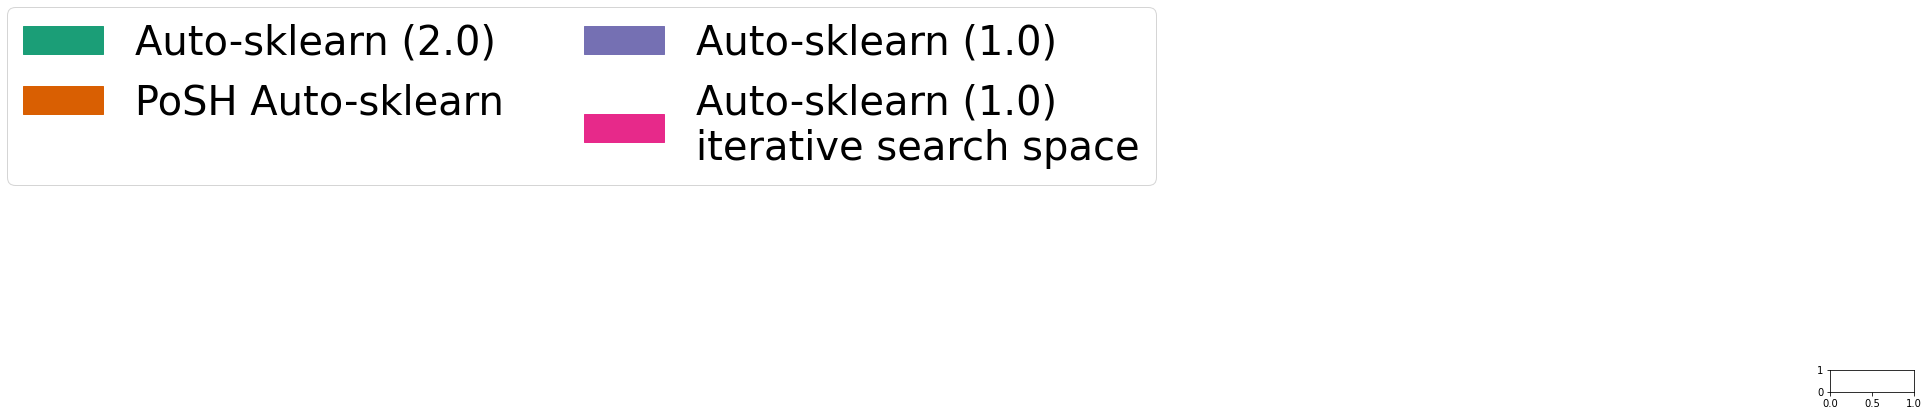

In [5]:
labels = (
    "Auto-sklearn (2.0)",
    "PoSH Auto-sklearn",
    "Auto-sklearn (1.0)",
    "Auto-sklearn (1.0) \niterative search space",
)
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
patches = [
    mpatches.Patch(color=color, label=label)
    for label, color in zip(labels, style_dc['colors'])]
fig.legend(patches, labels, loc='upper left', frameon=True, ncol=2,
           bbox_to_anchor=(0, 1.6, 0, 0), 
           borderaxespad=1., fontsize=style_dc["fontsize"]*2)
box = ax.get_position()
ax.set_position([box.x0 + 1.6, box.y0, box.width * 0.1, box.height * 0.1])
#plt.show()
#plt.tight_layout()
plt.savefig('/tmp/RQ1_legend.pdf', bbox_inches=matplotlib.transforms.Bbox.from_bounds(0, 0, 22, 6))

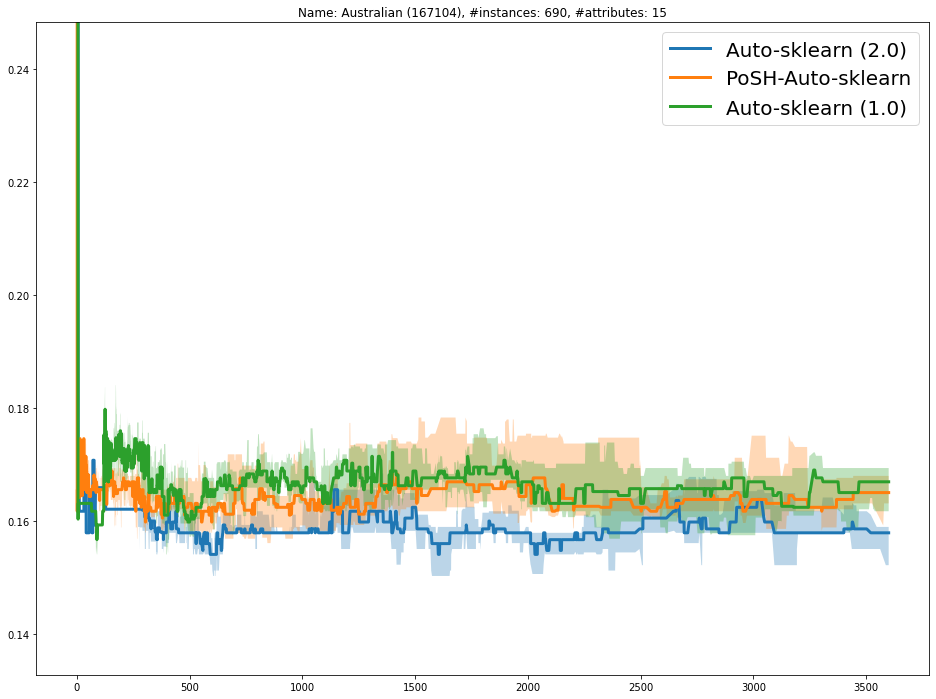

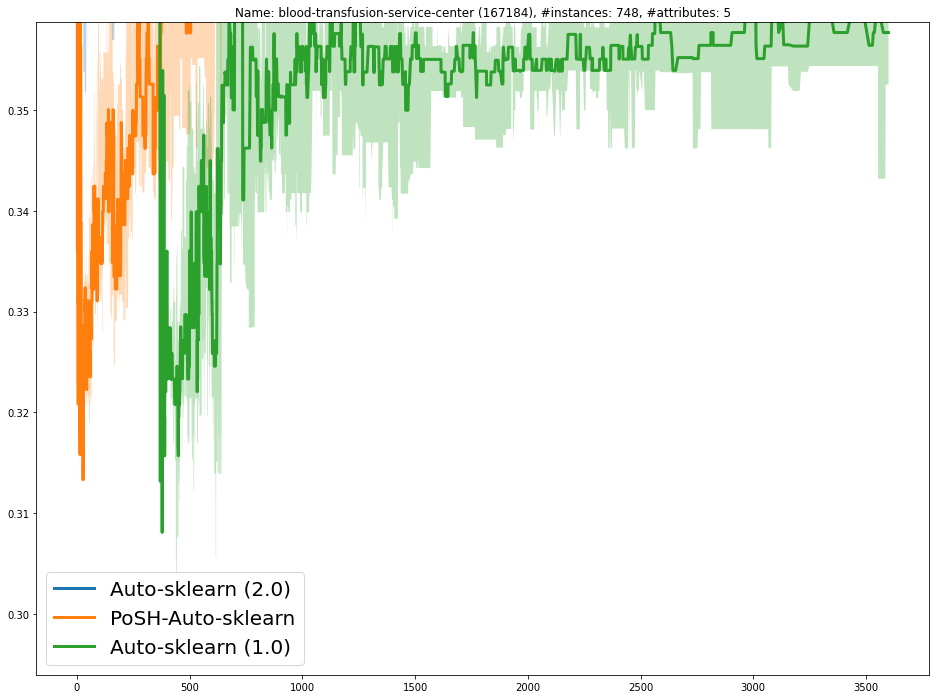

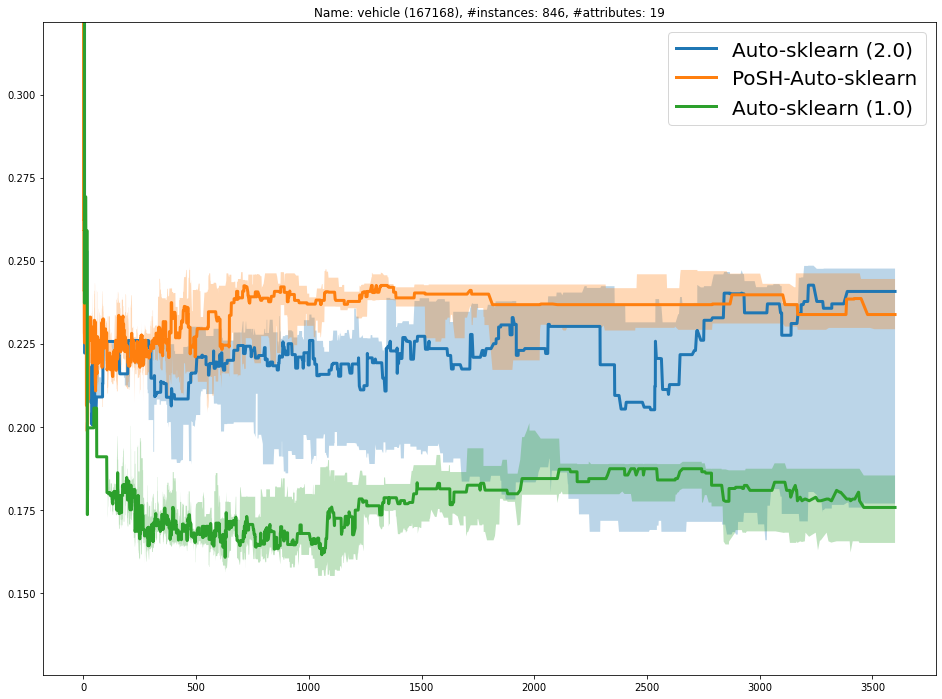

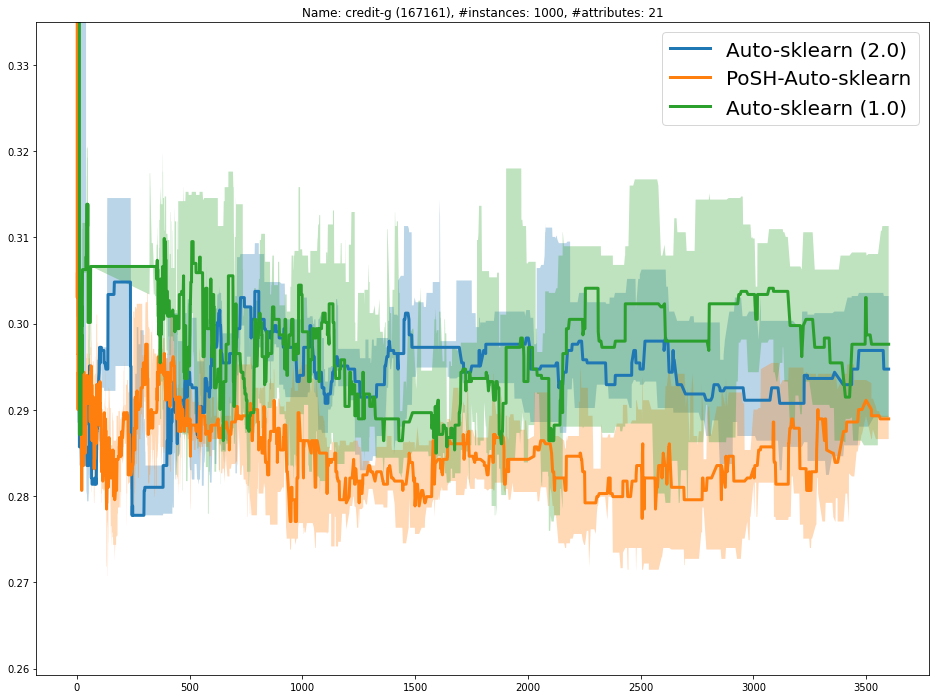

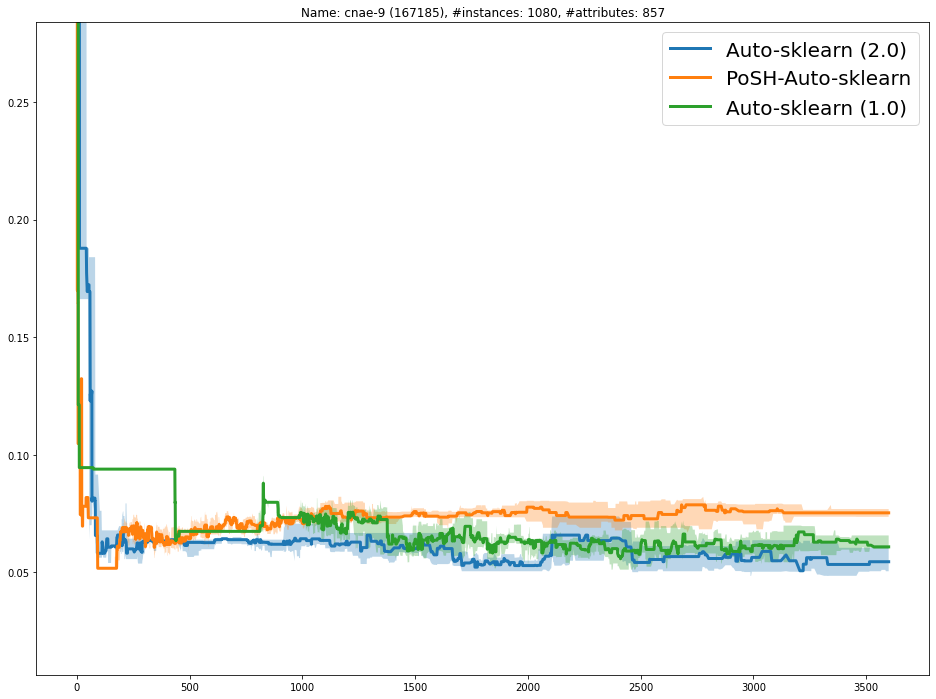

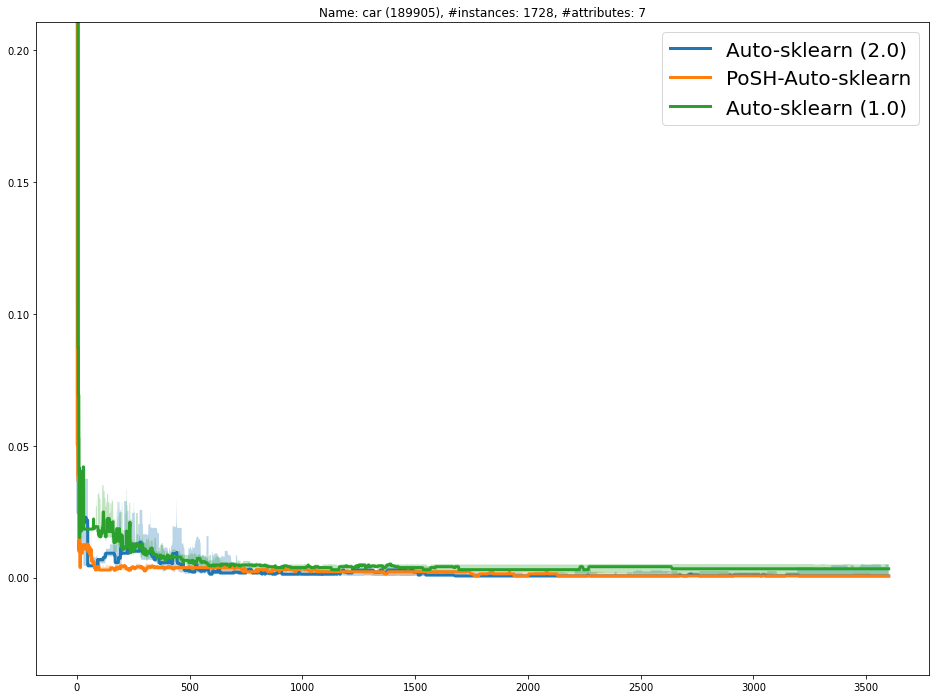

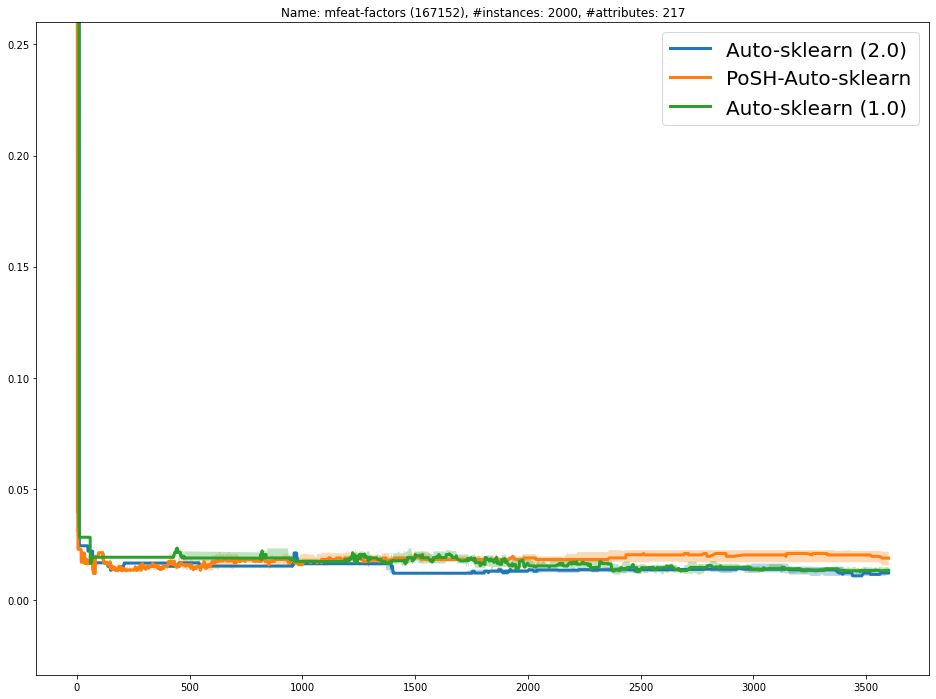

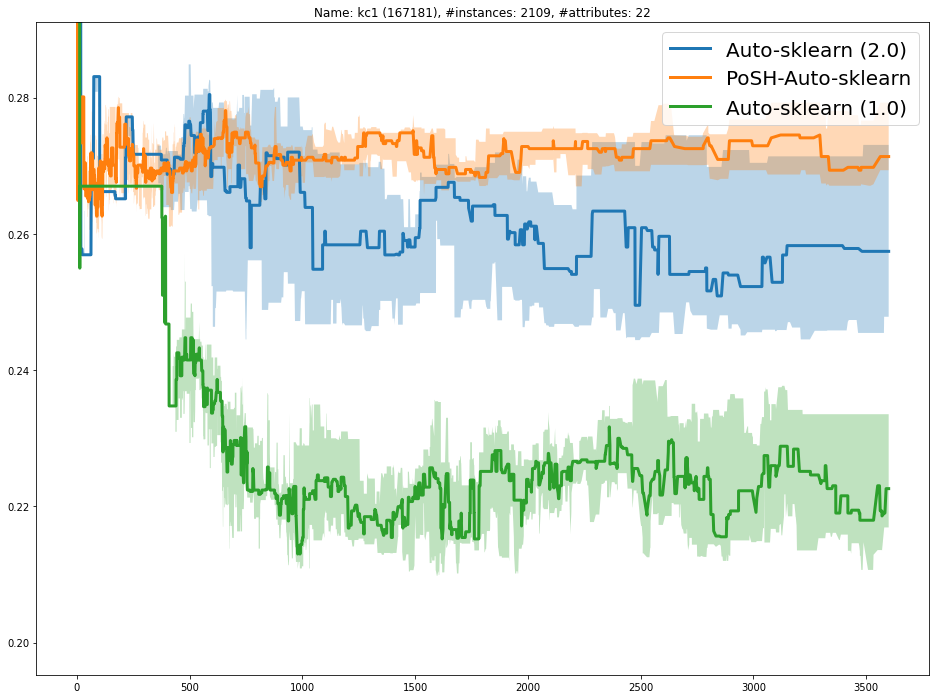

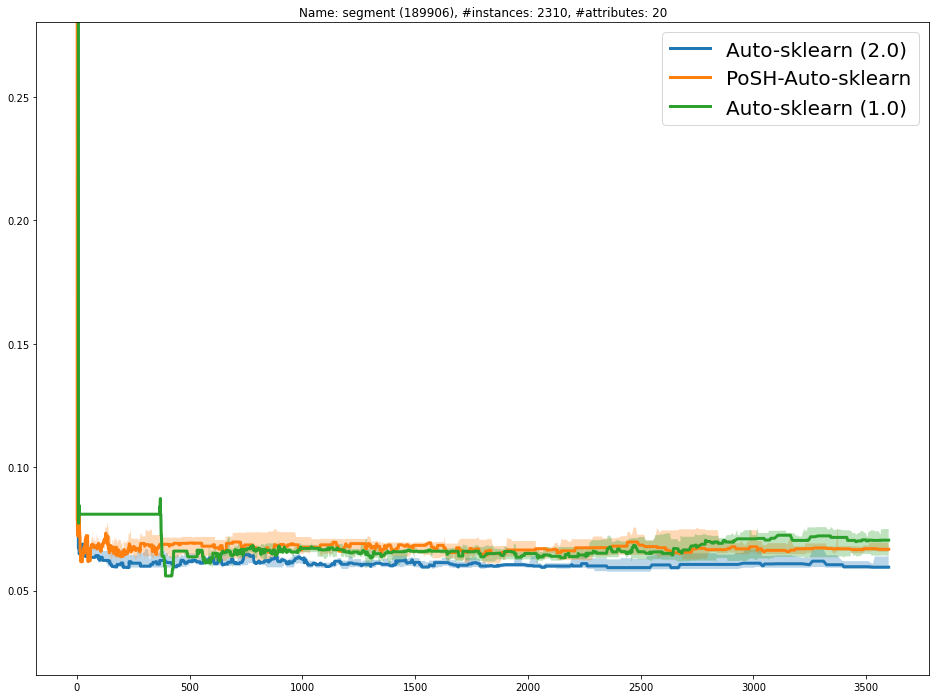

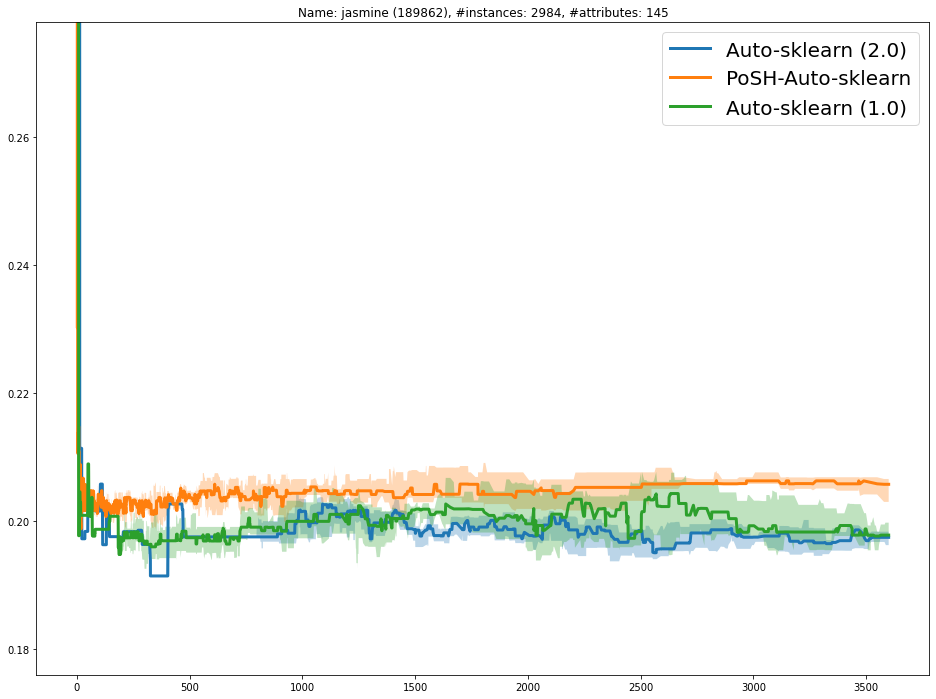

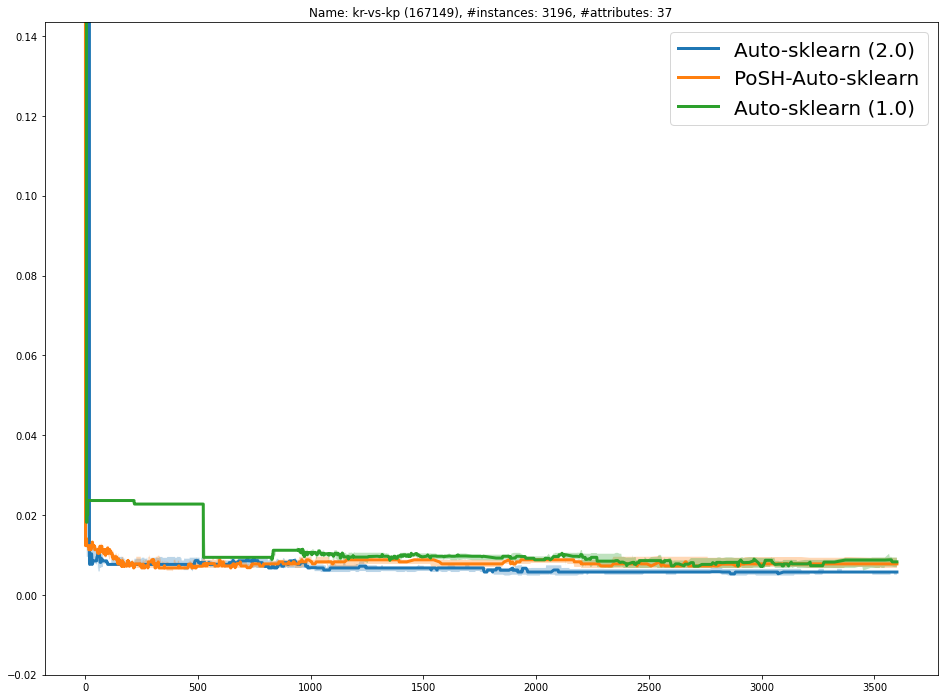

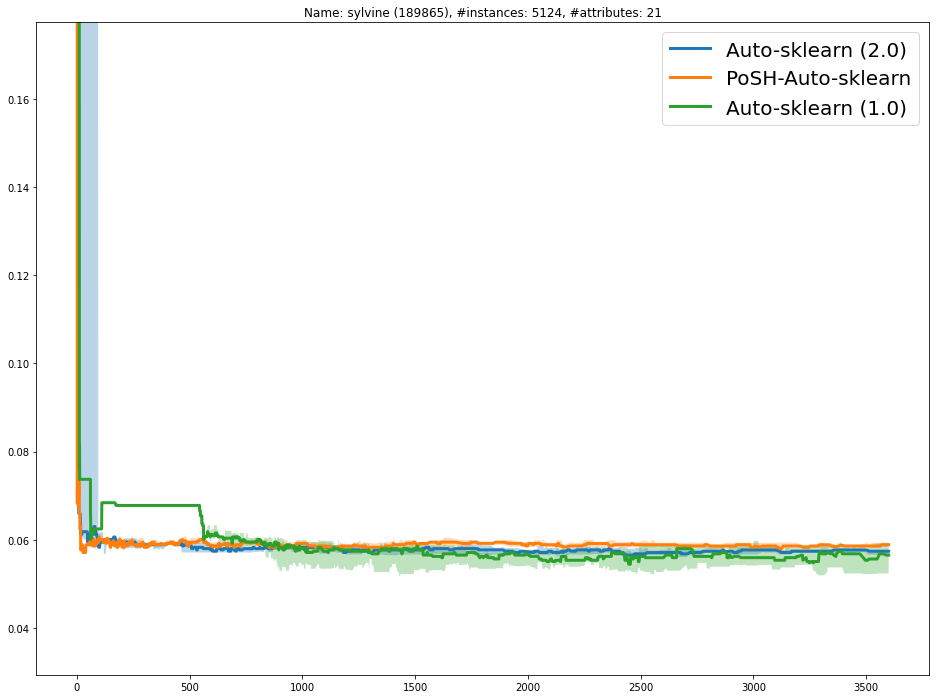

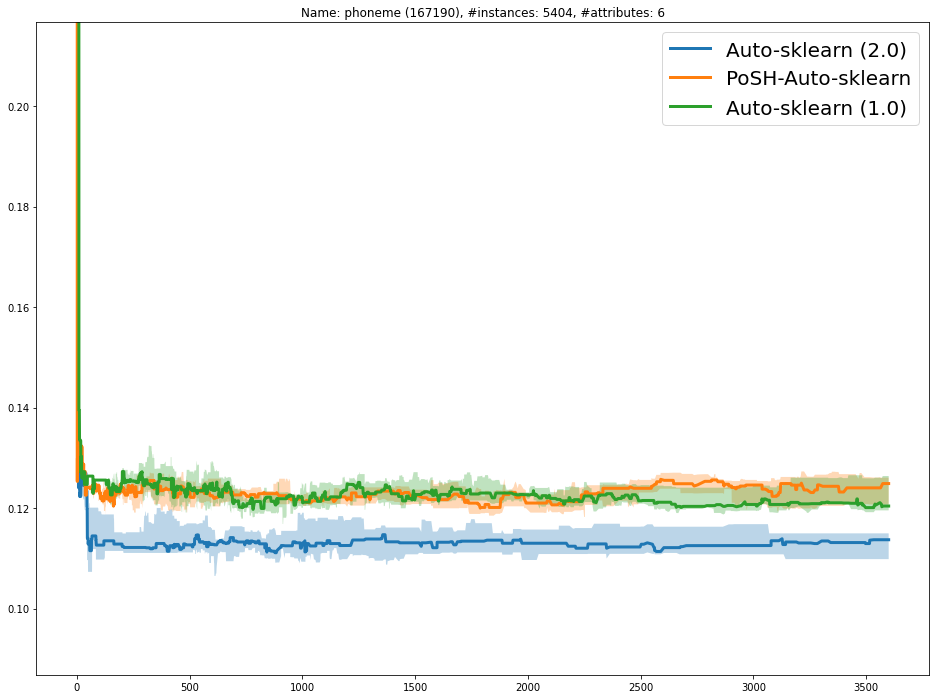

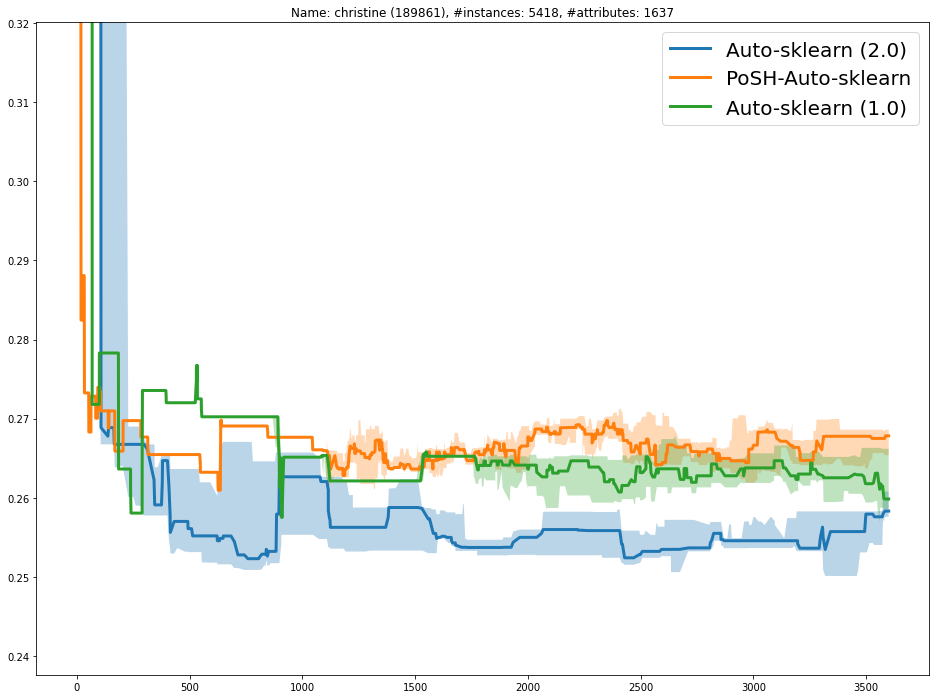

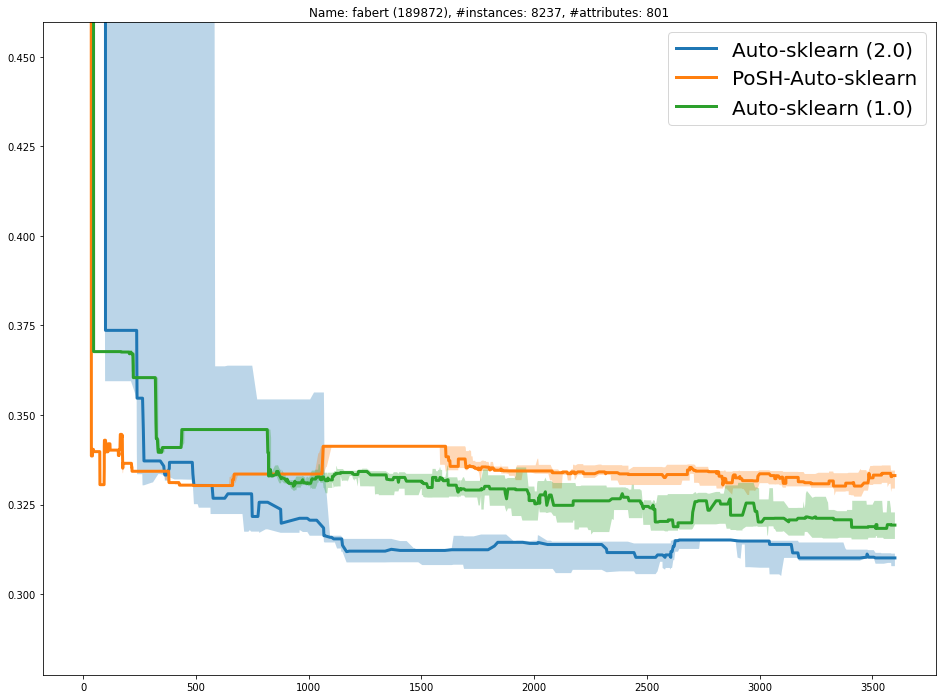

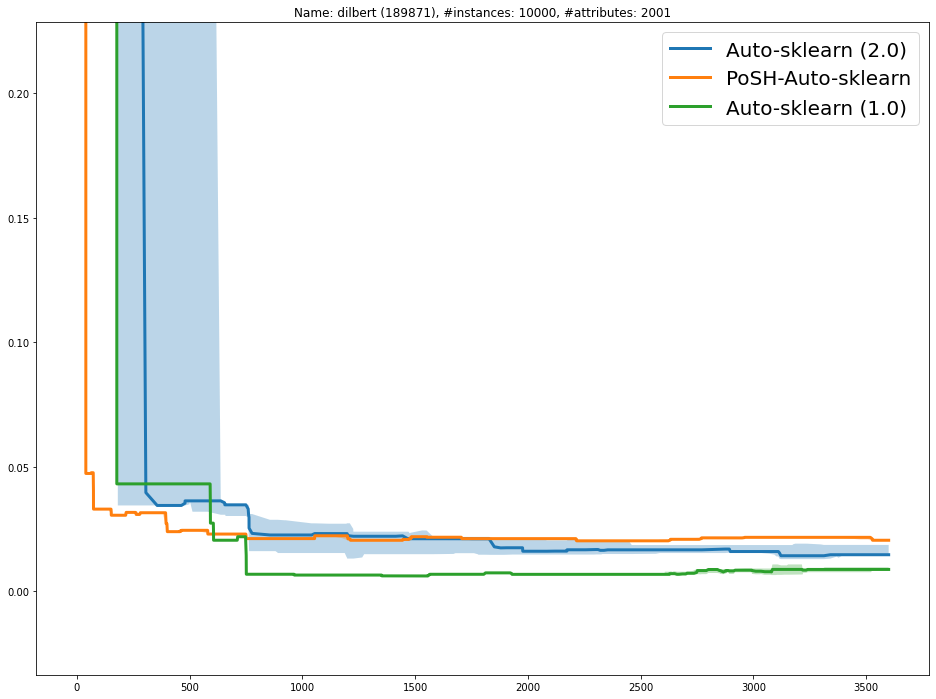

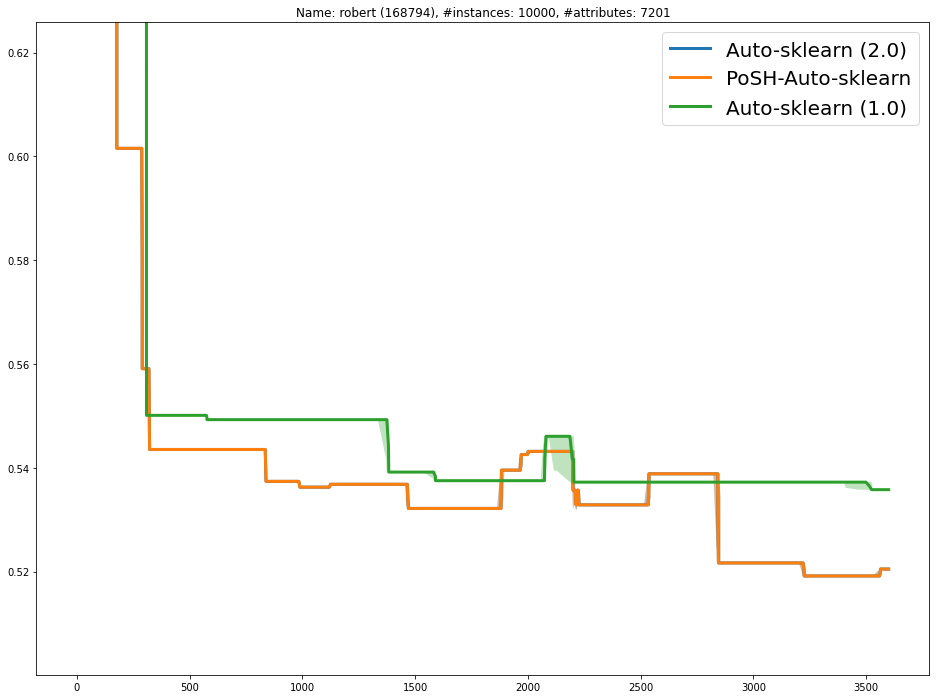

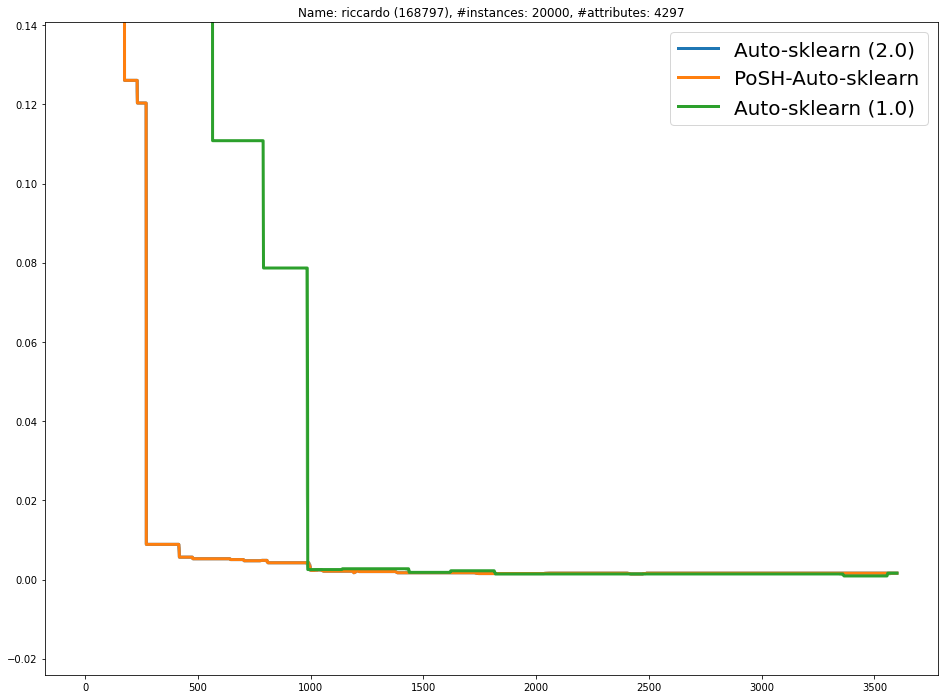

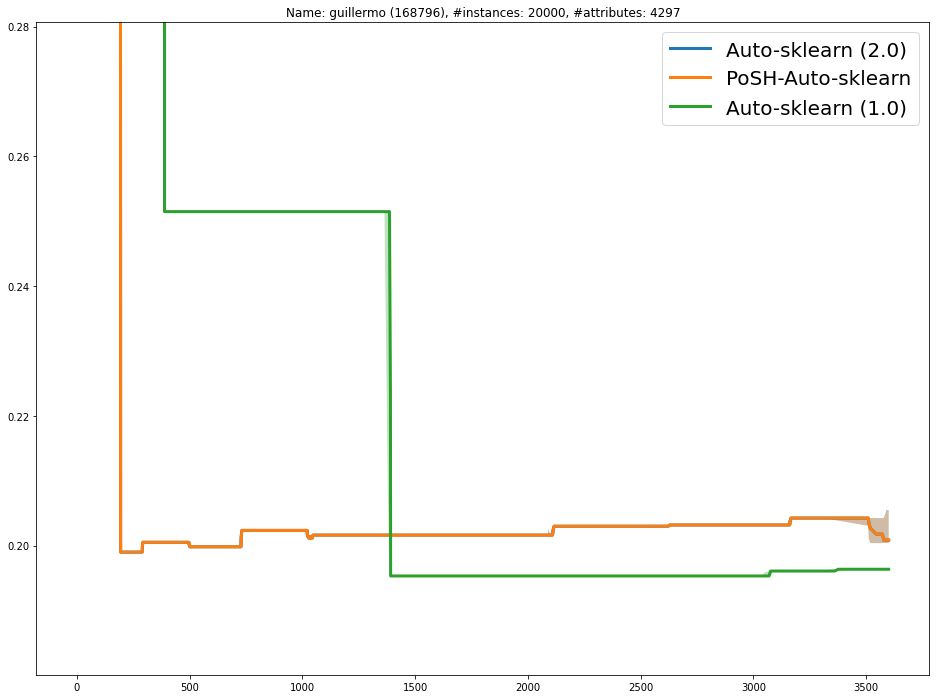

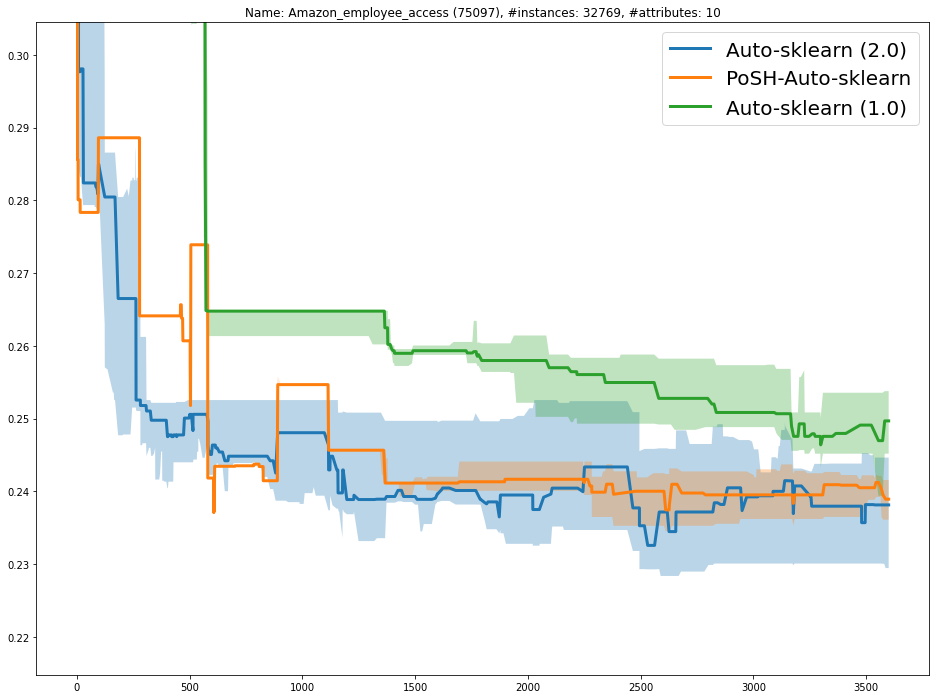

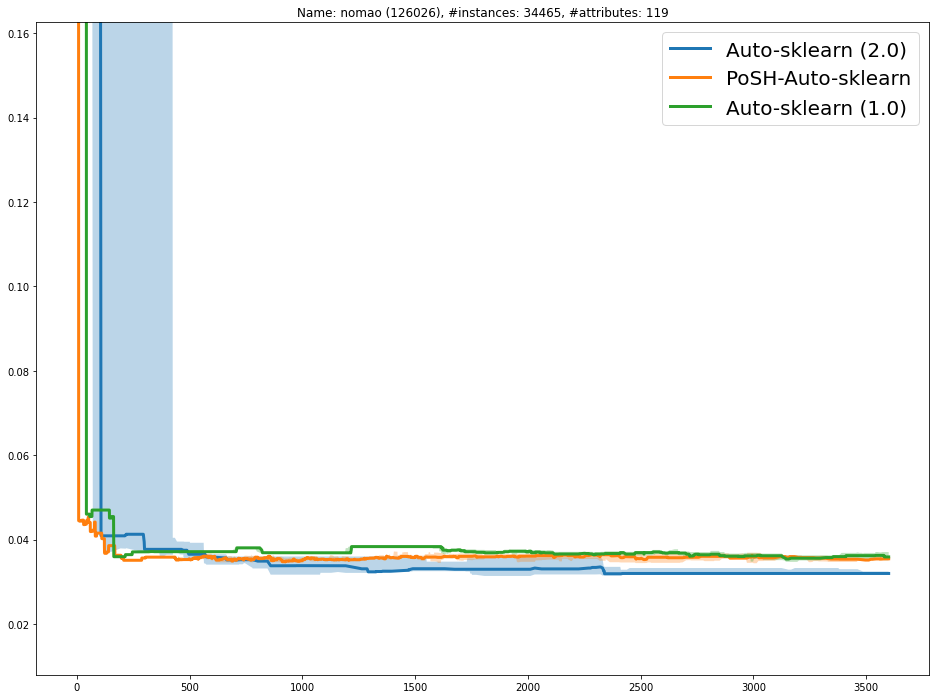

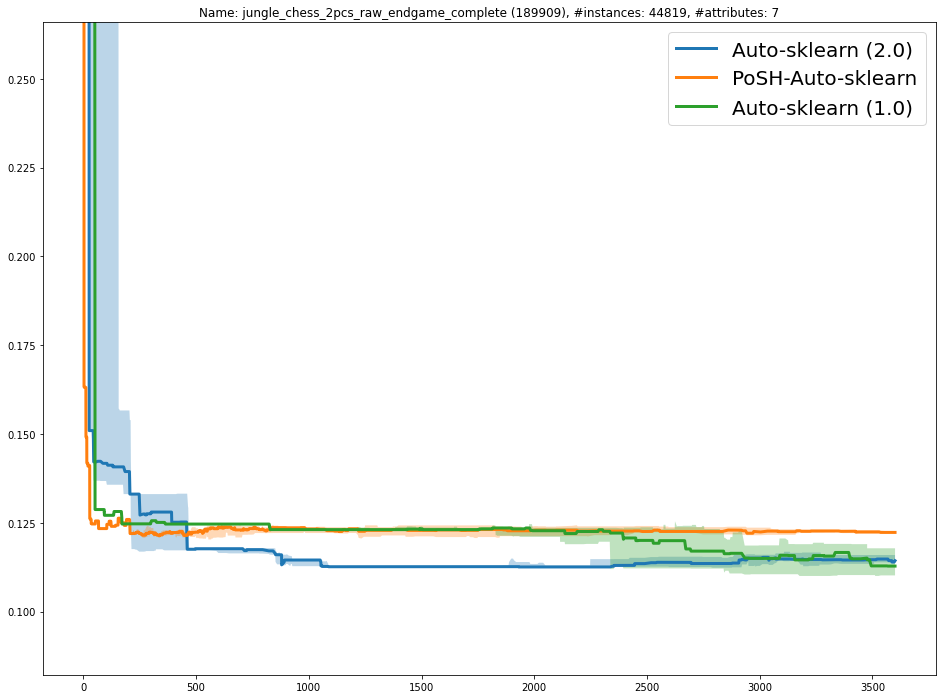

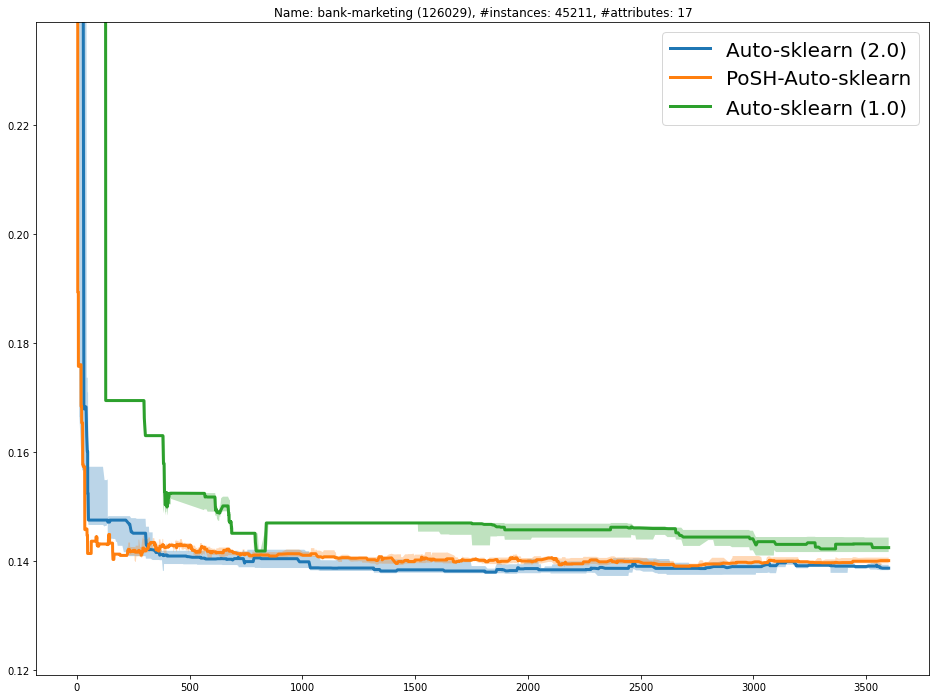

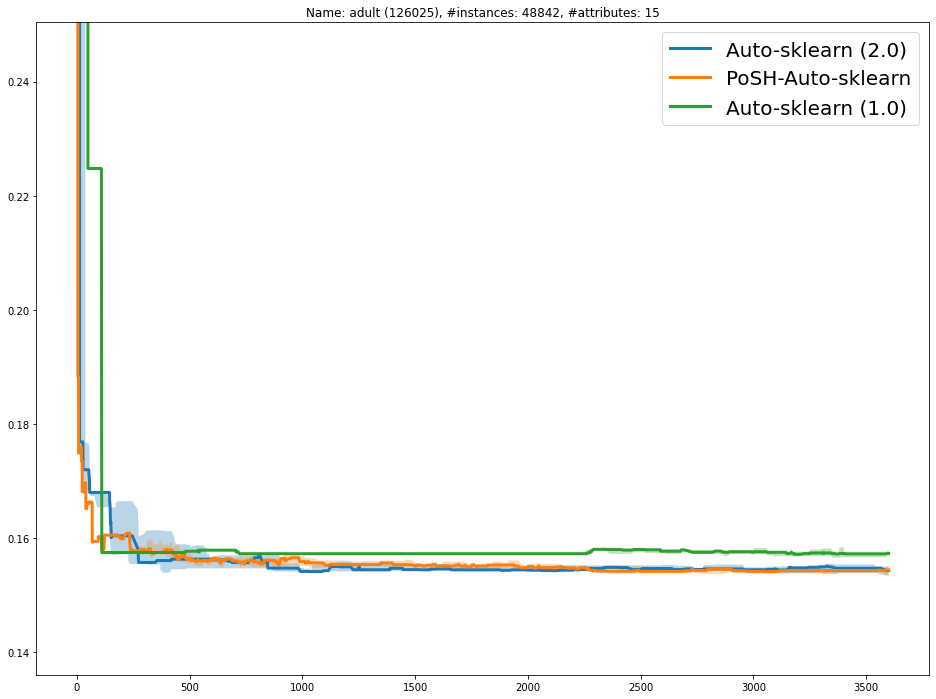

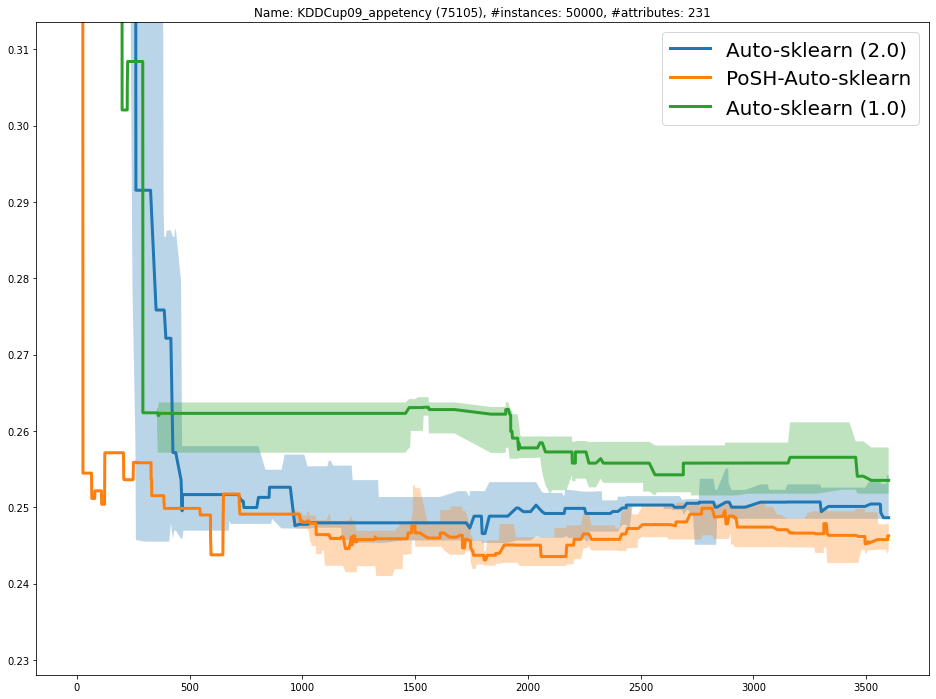

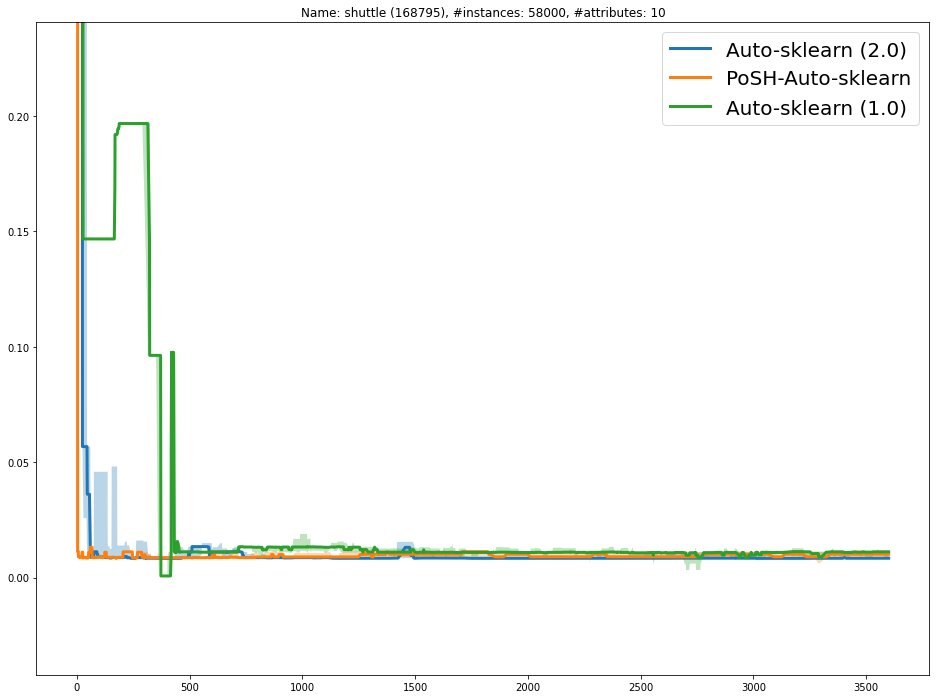

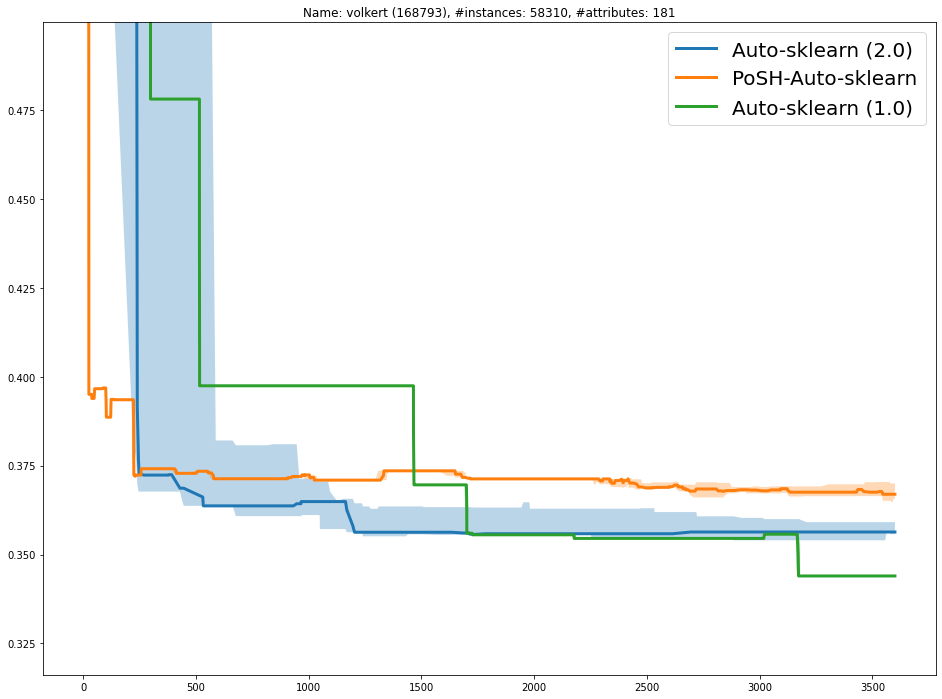

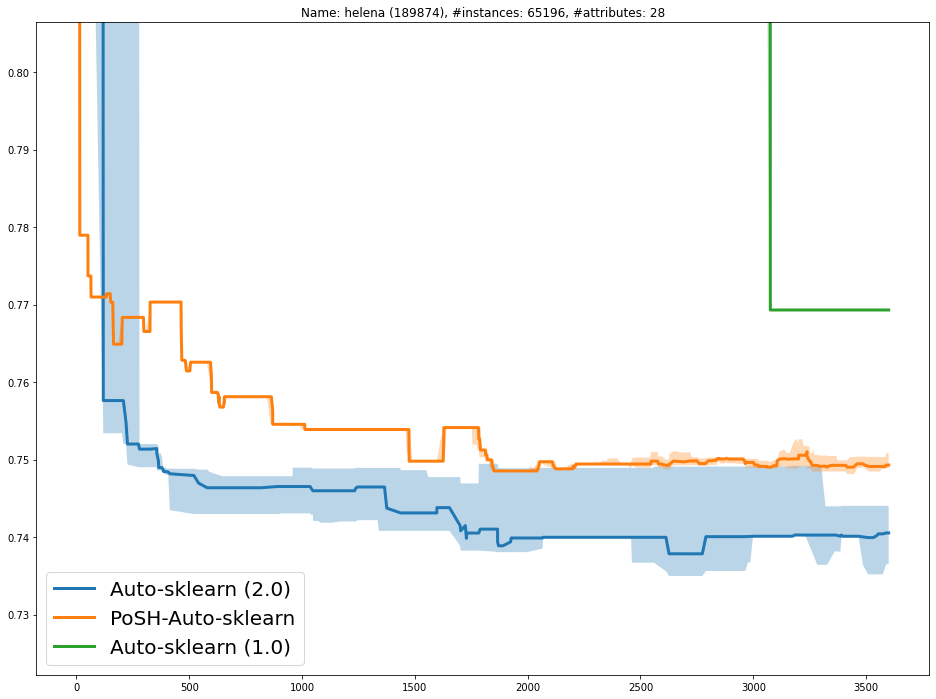

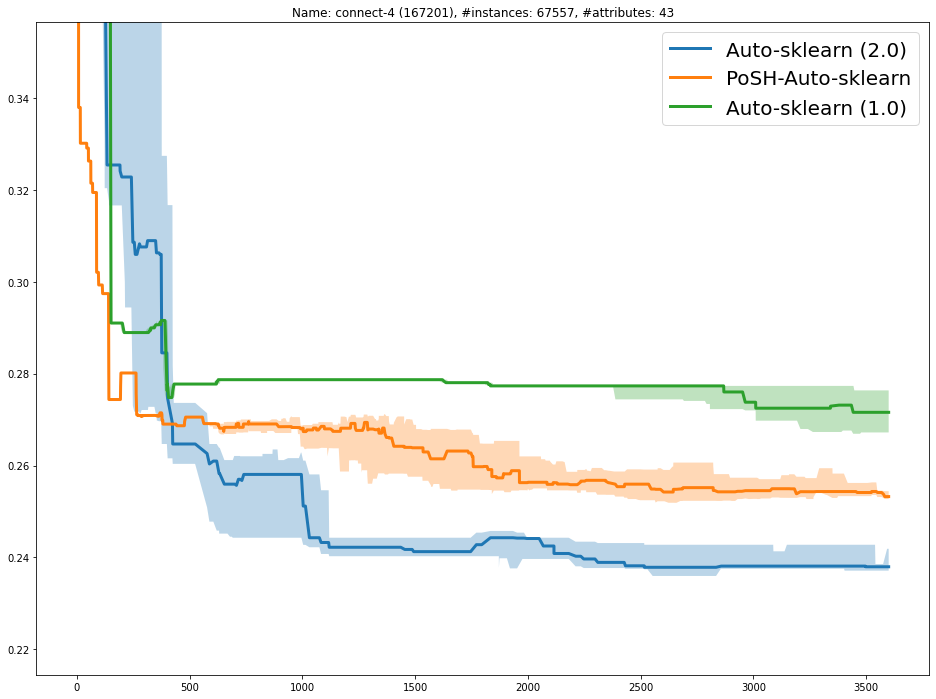

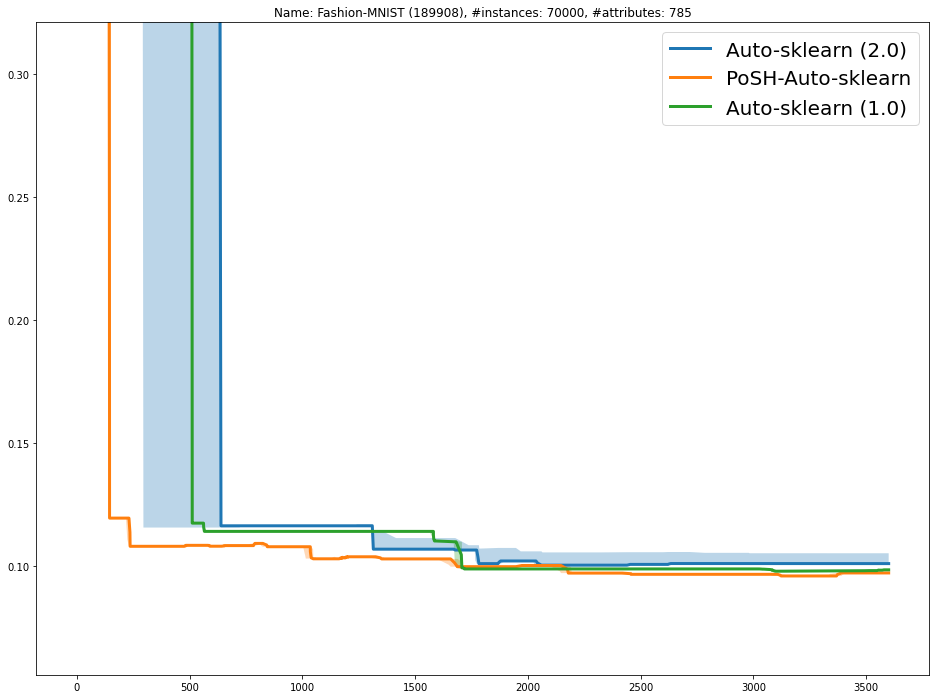

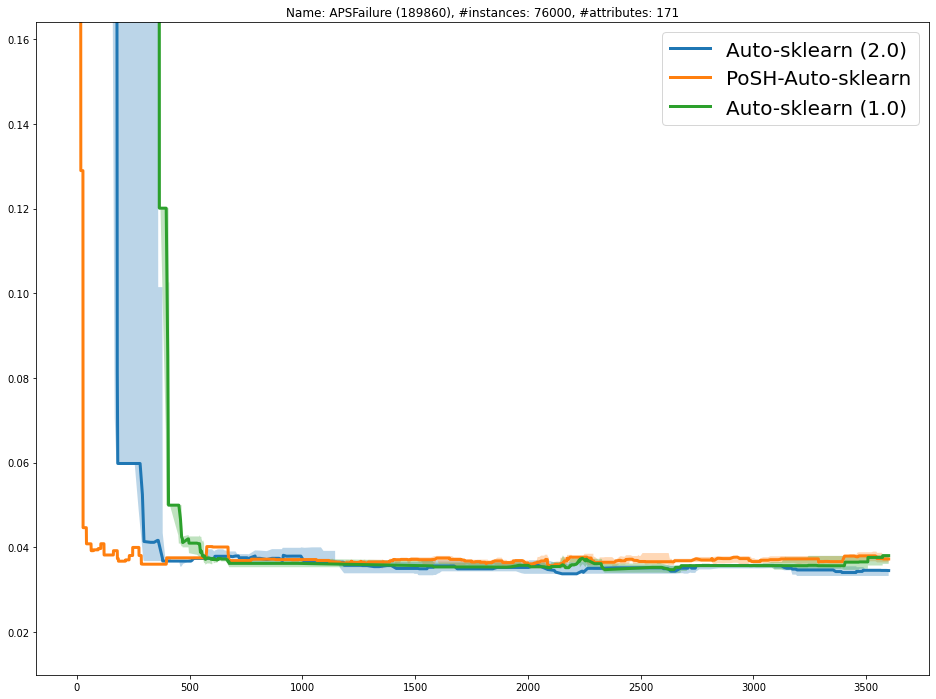

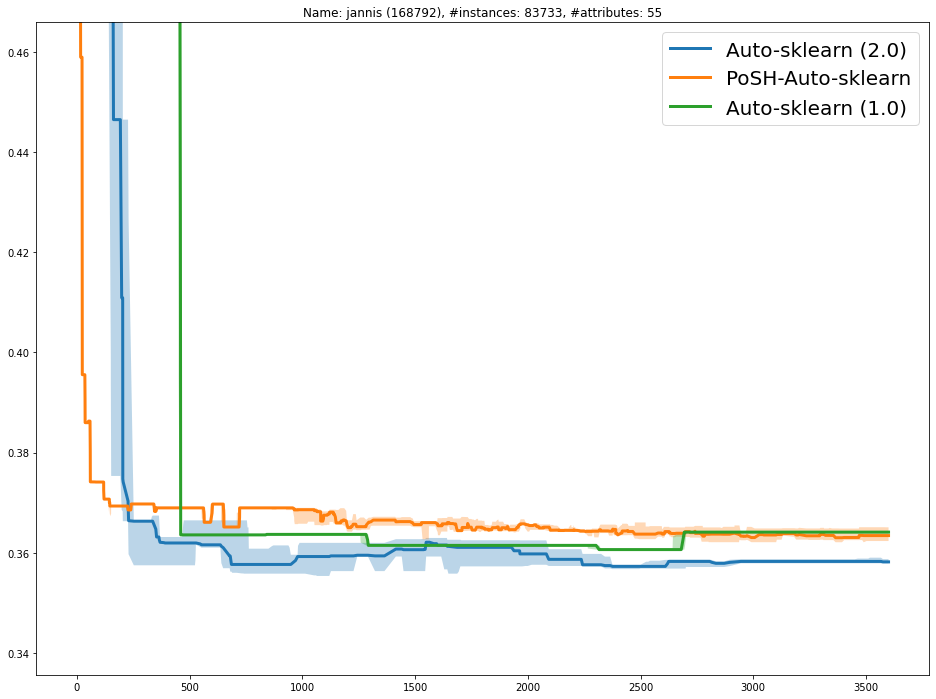

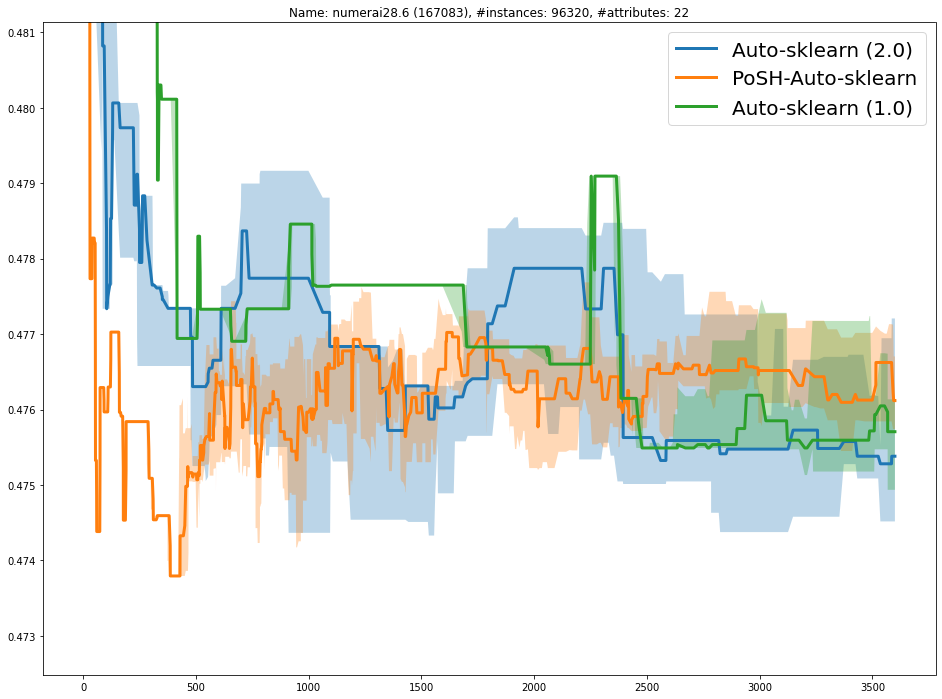

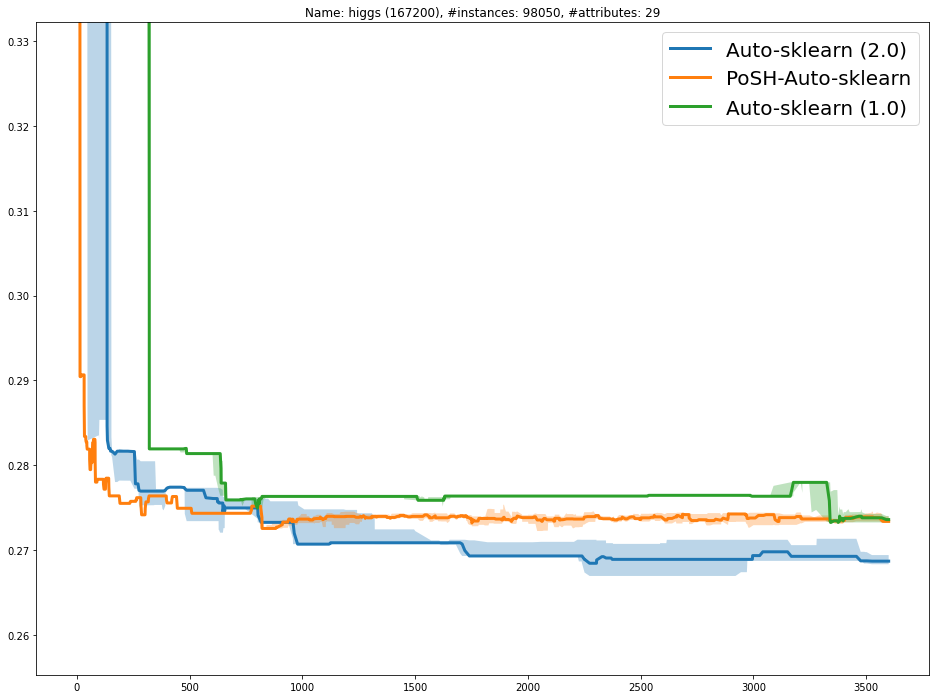

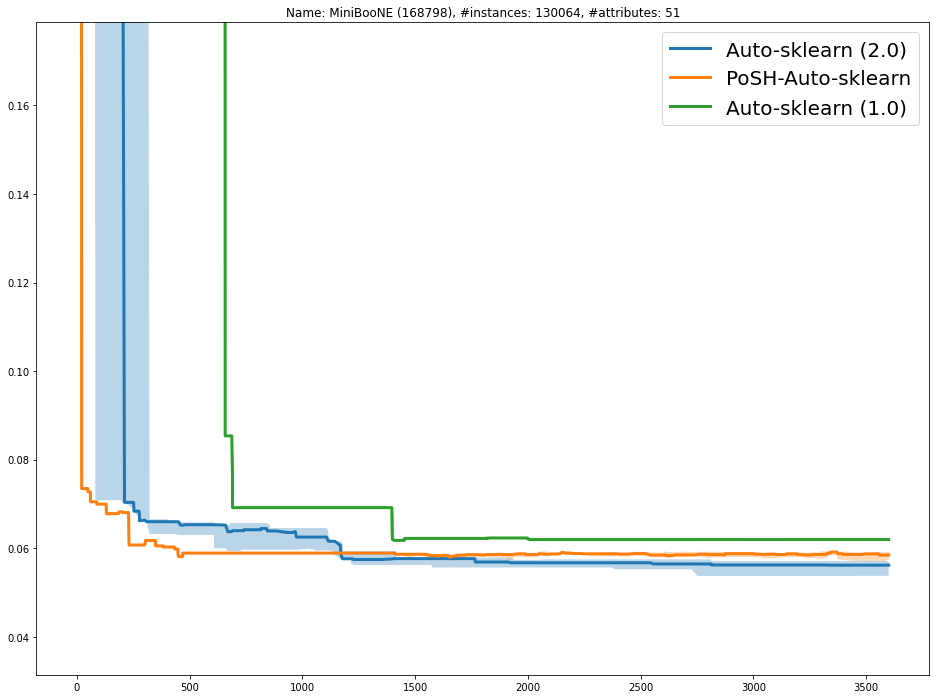

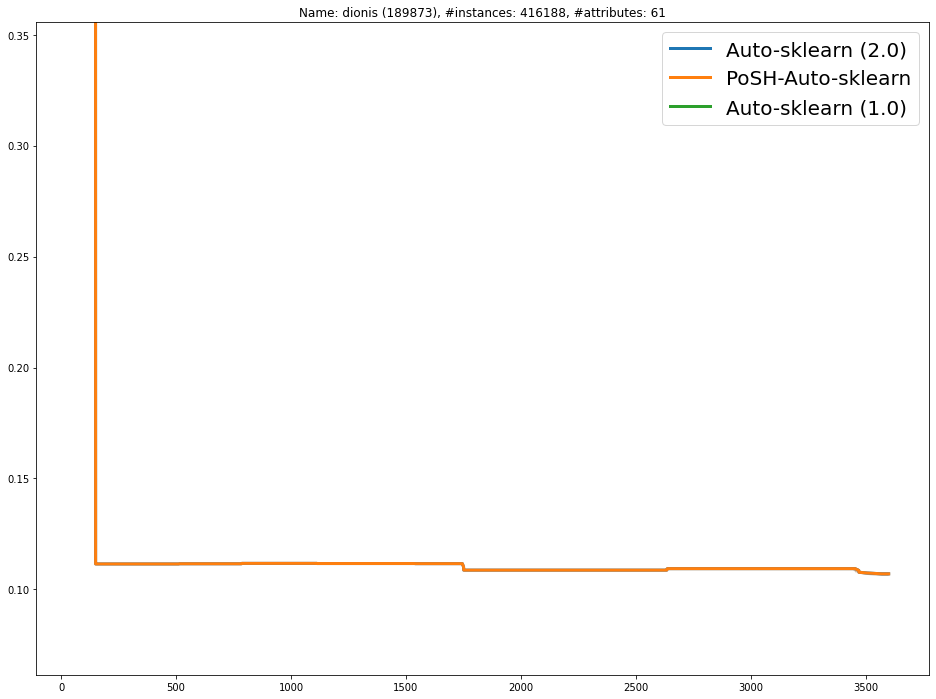

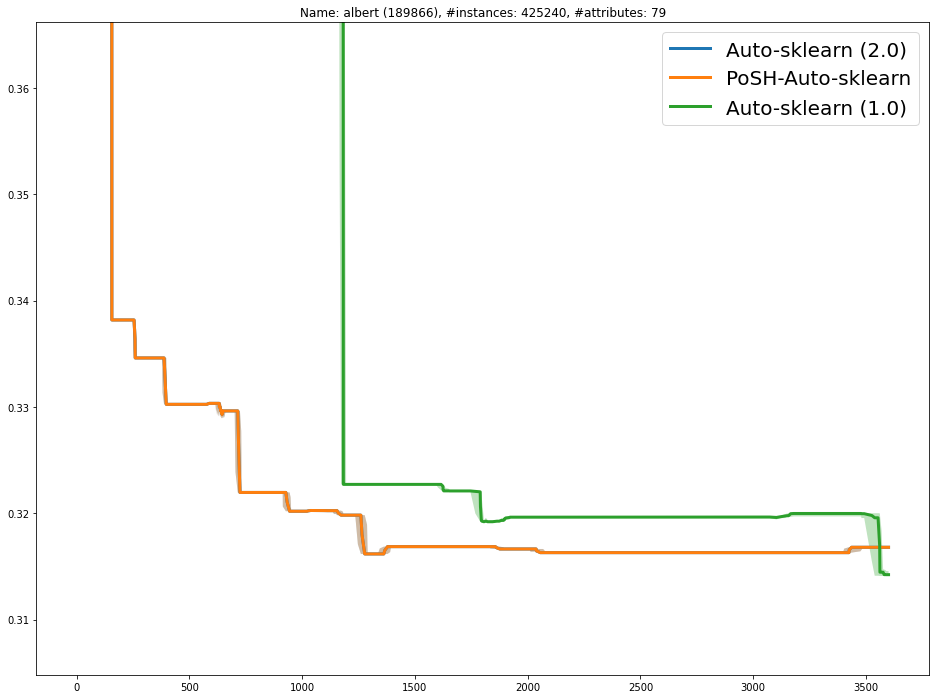

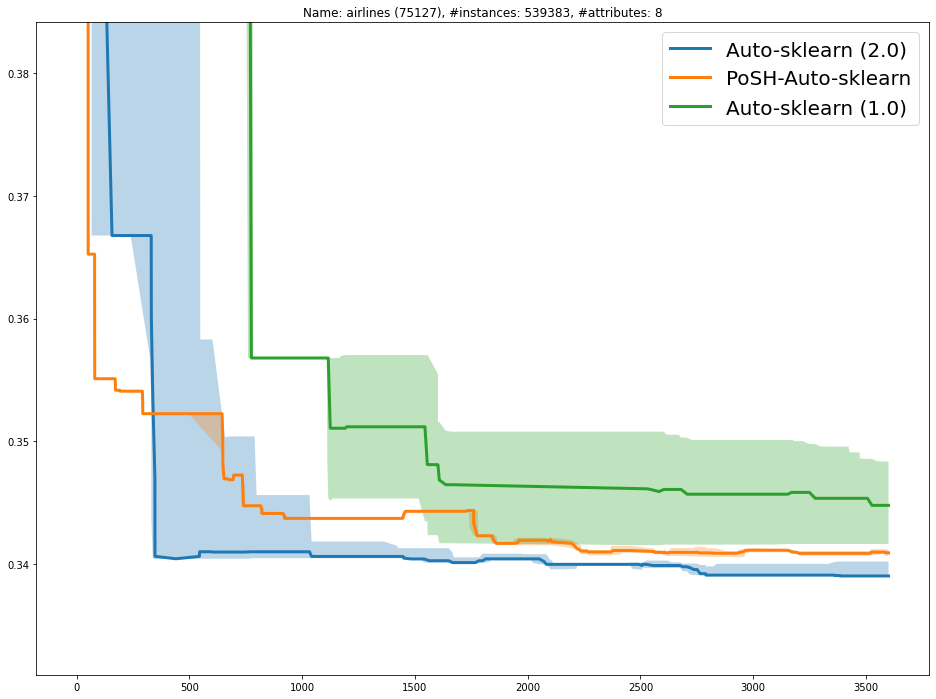

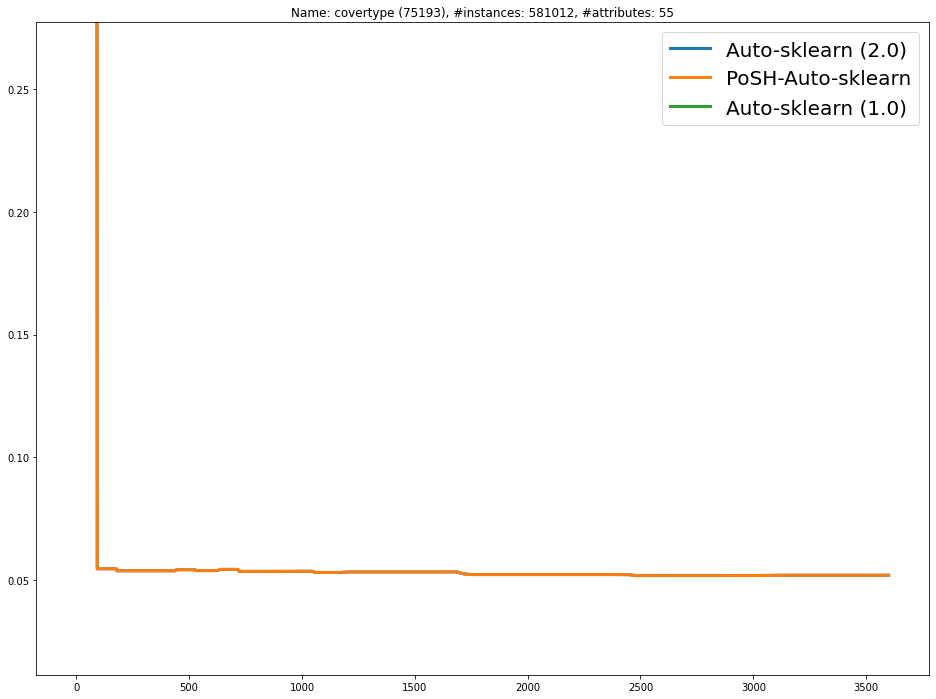

In [6]:
HORIZON = 60
for tid in task_ids_sorted_by_num_features:
    plt.figure(figsize=[16,12])
    colors = itertools.cycle(style_dc['colors'])
    for mode in list(valid_pretty[HORIZON].keys()):
        c = next(colors)
        tmp = pd.DataFrame(res_dc[HORIZON][tid][mode]).sort_index(axis=1).ffill(axis=1)
        med = tmp.median(axis=0)
        med.loc[HORIZON*60] = med.iloc[-1]
        low = tmp.quantile(0.25)
        low.loc[HORIZON*60] = low.iloc[-1]
        up = tmp.quantile(0.75, axis=0)
        up.loc[HORIZON*60] = up.iloc[-1]
        plt.plot(med.index, med.to_numpy(), label=valid_pretty[HORIZON][mode], linewidth=3)
        plt.fill_between(med.index, low, up, alpha=0.3)
    plt.title('Name: %s (%d), #instances: %d, #attributes: %d' % (
        tasks.loc[tid, 'name'], tid, tasks.loc[tid, 'NumberOfInstances'], tasks.loc[tid, 'NumberOfFeatures']))
    plt.legend(fontsize=20)
    plt.ylim([plt.ylim()[0], plt.ylim()[0] + 0.3*(plt.ylim()[1]-plt.ylim()[0])])
    #plt.yscale("log")
    plt.show()

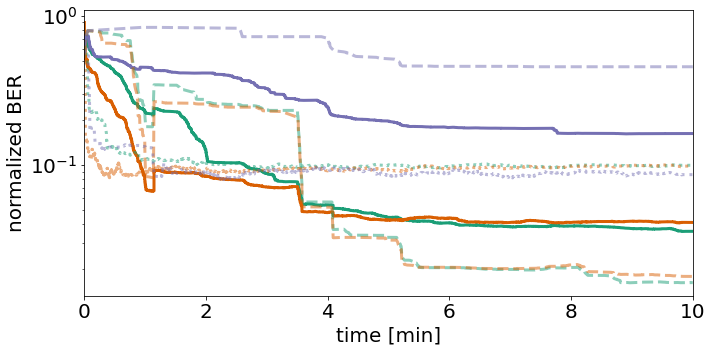

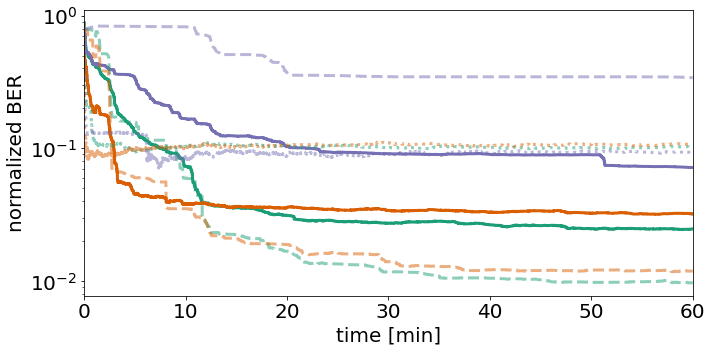

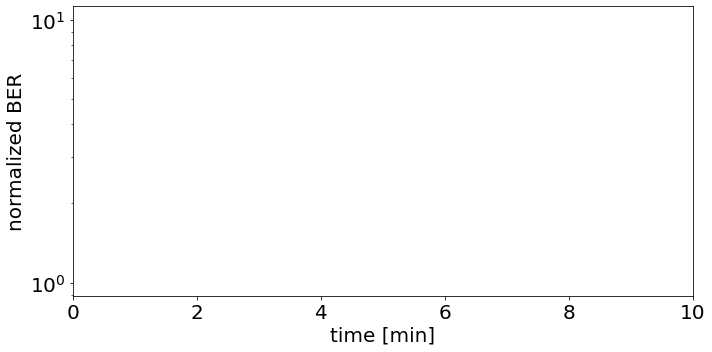

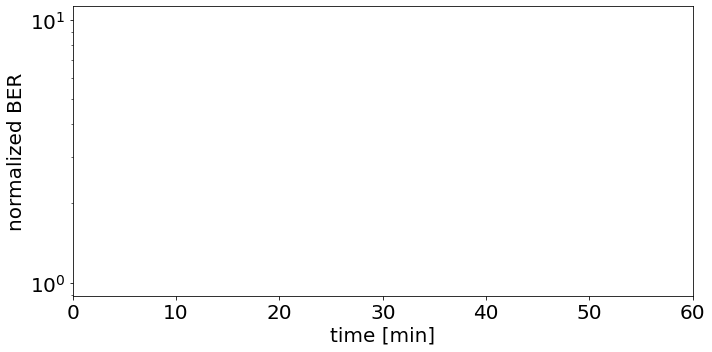

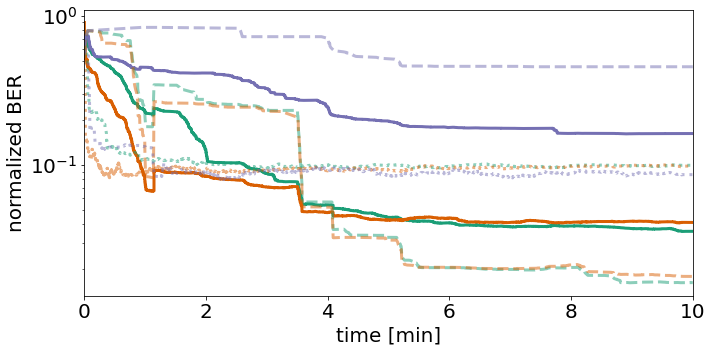

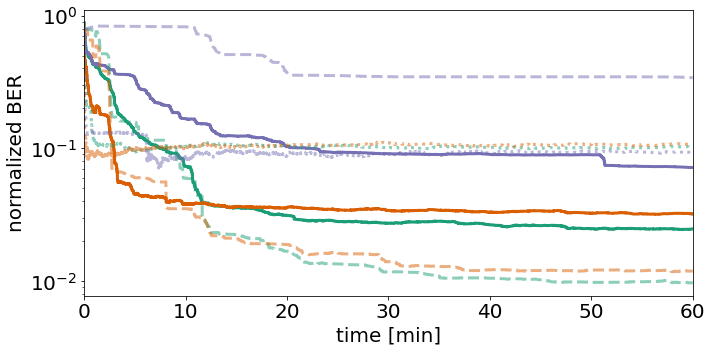

In [7]:
# Plot average BER across all datasets
for use_ensemble in ((True, ), (False, ), (True, False)):
    for HORIZON in (10, 60):
        model_list = []
        for m in valid_pretty[HORIZON].keys():
            if m[1] in use_ensemble:
                model_list.append(m)

        average_plot(model_list=model_list, res_dc=res_dc, valid_pretty=valid_pretty,
                     horizon=HORIZON, task_ids_sorted_by_num_features=task_ids_sorted_by_num_features,
                     min_diff_dc=min_diff_dc, figsize=(10, 5), legend=False)
        plt.yscale("log")
        plt.tight_layout()
        plt.savefig('/tmp/RQ1_%sMIN_%s_perf.pdf' % (
            str(HORIZON), "ens" if use_ensemble[0] is True and len(use_ensemble) == 1 else "other")
        )
        plt.show()

In [8]:
# Assume we have either all or no models
horizon_list = sorted(list(valid_pretty.keys()))
model_list = {}
for h in horizon_list:
    model_list[h] = []
    for m in valid_pretty[h].keys():
        if valid_pretty[h][m] == "Auto-sklearn (2.0)":
            continue
        model_list[h].append(m)

tab_data, stat_test_data = collect_data_for_final_table(
    model_list, res_dc, valid_pretty, horizon_list,
    task_ids_sorted_by_num_features, min_diff_dc, n_seeds=n_seeds)
not_different = do_wilcoxon_test(stat_test_data, model_list, horizon_list, valid_pretty, exclude=["Oracle",])

Not different with 10 mins:
	 
Not different with 60 mins:
	 PoSH-Auto-sklearn vs Auto-sklearn (1.0): 0.455554


In [9]:
df = pd.DataFrame(tab_data)
class formatter:
    def __call__(self, value):
        return '$%2.2f$' % value

formatters = [formatter() for _ in range(4)]
print(df)
print(df.to_latex(formatters=formatters, escape=False))
print(not_different)

                       10  STD 10    60  STD 60
PoSH-Auto-sklearn    4.11    0.09  3.19    0.12
Auto-sklearn (1.0)  16.21    0.27  7.17    0.30
\begin{tabular}{lrrrr}
\toprule
{} &      10 & STD 10 &     60 & STD 60 \\
\midrule
PoSH-Auto-sklearn  &  $4.11$ & $0.09$ & $3.19$ & $0.12$ \\
Auto-sklearn (1.0) & $16.21$ & $0.27$ & $7.17$ & $0.30$ \\
\bottomrule
\end{tabular}

{10: [], 60: [('PoSH-Auto-sklearn', 'Auto-sklearn (1.0)', 0.4555544340233111)]}


In [10]:
# Assume we have either all or no models
horizon_list = sorted(list(valid_pretty.keys()))
model_list = {}
for h in horizon_list:
    model_list[h] = []
    for m in valid_pretty[h].keys():
        model_list[h].append(m)

tab_data, stat_test_data = collect_data_for_final_table(
    model_list, res_dc, valid_pretty, horizon_list,
    task_ids_sorted_by_num_features, min_diff_dc, n_seeds=n_seeds)
not_different = do_wilcoxon_test(stat_test_data, model_list, horizon_list, valid_pretty, exclude=["Oracle",])

Not different with 10 mins:
	 
Not different with 60 mins:
	 


In [11]:
df = pd.DataFrame(tab_data)
class formatter:
    def __call__(self, value):
        return '$%2.2f$' % value

formatters = [formatter() for _ in range(4)]
print(df)
print(df.to_latex(formatters=formatters, escape=False))
print(not_different)

                       10  STD 10    60  STD 60
Auto-sklearn (2.0)   3.58    0.23  2.47    0.18
PoSH-Auto-sklearn    4.11    0.09  3.19    0.12
Auto-sklearn (1.0)  16.21    0.27  7.17    0.30
\begin{tabular}{lrrrr}
\toprule
{} &      10 & STD 10 &     60 & STD 60 \\
\midrule
Auto-sklearn (2.0) &  $3.58$ & $0.23$ & $2.47$ & $0.18$ \\
PoSH-Auto-sklearn  &  $4.11$ & $0.09$ & $3.19$ & $0.12$ \\
Auto-sklearn (1.0) & $16.21$ & $0.27$ & $7.17$ & $0.30$ \\
\bottomrule
\end{tabular}

{10: [], 60: []}


Plotting 3 models
0 / 1000
50 / 1000
100 / 1000
150 / 1000
200 / 1000
250 / 1000
300 / 1000
350 / 1000
400 / 1000
450 / 1000
500 / 1000
550 / 1000
600 / 1000
650 / 1000
700 / 1000
750 / 1000
800 / 1000
850 / 1000
900 / 1000
950 / 1000


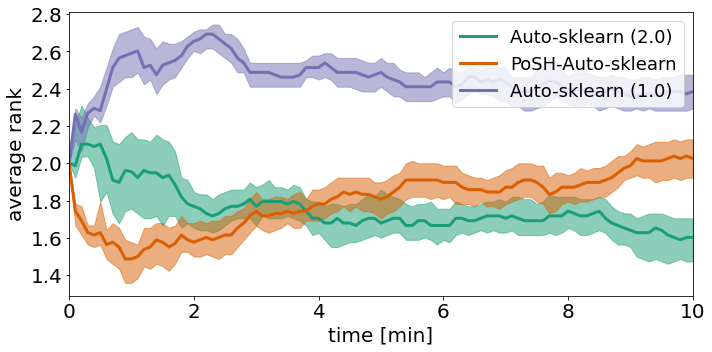

Plotting 3 models
0 / 1000
50 / 1000
100 / 1000
150 / 1000
200 / 1000
250 / 1000
300 / 1000
350 / 1000
400 / 1000
450 / 1000
500 / 1000
550 / 1000
600 / 1000
650 / 1000
700 / 1000
750 / 1000
800 / 1000
850 / 1000
900 / 1000
950 / 1000


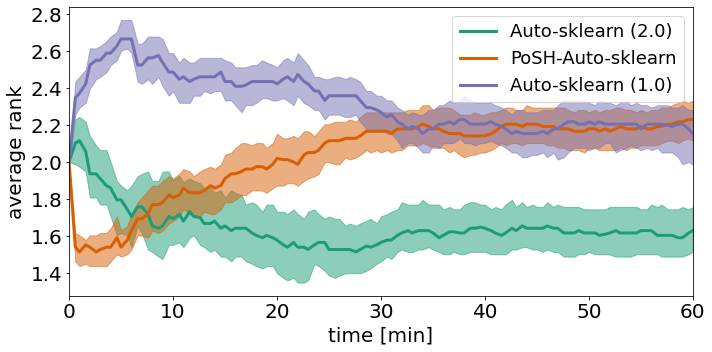

In [12]:
for HORIZON in (10, 60):
    model_list = []
    for m in valid_pretty[HORIZON].keys():
        model_list.append(m)
    rank(model_list, res_dc, valid_pretty, HORIZON, task_ids_sorted_by_num_features, n_iter='all', 
         steplength=max(1, int(HORIZON * 60 / 100)), legend=True)
    plt.legend(fontsize=style_dc["fontsize"] - 2, loc="upper right")
    plt.tight_layout()
    plt.savefig('/tmp/RQ1_%sMIN_rank.pdf' % str(HORIZON))
    plt.show()

In [13]:
def table_per_dataset(model_list, res_dc, valid_pretty, horizon,
                      task_ids_sorted_by_num_features, min_diff_dc, n_seeds=n_seeds):
    # Generate data for final table and statistical testing
    tab_data = {}

    for mode in model_list:
        assert mode in valid_pretty[horizon], (mode, valid_pretty[horizon].keys())
        tab_data[valid_pretty[horizon][mode]] = {}
        # Use label, not actual key
        # Get means per tid
        for tid in task_ids_sorted_by_num_features:
            tmp = pd.DataFrame(res_dc[horizon][tid][mode]).sort_index(axis=1).ffill(axis=1).iloc[:, -1]
            assert tmp.shape == (n_seeds, )
            tmp = (tmp - min_diff_dc[tid][0]) / min_diff_dc[tid][1]
            tab_data[valid_pretty[horizon][mode]][tid] = tmp.mean()
    tab_data = pd.DataFrame(tab_data)
    return tab_data

tab_data_per_horizon = {}
for h in (10, 60):
    horizon_list = sorted(list(valid_pretty.keys()))
    model_list = []
    for m in valid_pretty[h].keys():
        if m[1]:
            model_list.append(m)

    tab_data = table_per_dataset(model_list, res_dc, valid_pretty, h,
                                 task_ids_sorted_by_num_features, min_diff_dc, n_seeds=n_seeds)
    tab_data_per_horizon[h] = tab_data

In [14]:
tab_data_per_horizon[10]

,Auto-sklearn (2.0),PoSH-Auto-sklearn,Auto-sklearn (1.0)
167104,0.057783,0.051228,0.059361
167184,0.225798,0.206287,0.188655
167168,0.093241,0.122120,0.047550
167161,0.092994,0.079140,0.103503
167185,0.026758,0.031456,0.030781
189905,0.001507,0.005000,0.005811
167152,0.007251,0.011391,0.013490
167181,0.088478,0.084815,0.013152
189906,0.014402,0.018774,0.012169
189862,0.039364,0.044540,0.034224


In [15]:
tab_data_per_horizon[60]

,Auto-sklearn (2.0),PoSH-Auto-sklearn,Auto-sklearn (1.0)
167104,0.050175,0.065680,0.063526
167184,0.219896,0.208021,0.197362
167168,0.112345,0.131477,0.067985
167161,0.109873,0.091242,0.115287
167185,0.019562,0.039819,0.025241
189905,0.003841,0.001293,0.004380
167152,0.007548,0.013624,0.008537
167181,0.068584,0.094342,0.003699
189906,0.010523,0.019238,0.019782
189862,0.031310,0.044129,0.033533


In [16]:
print(tab_data_per_horizon[10]["Auto-sklearn (1.0)"].mean())
print(tab_data_per_horizon[10]["PoSH-Auto-sklearn"].mean())
print(tab_data_per_horizon[10]["Auto-sklearn (2.0)"].mean())
print(tab_data_per_horizon[10]["Auto-sklearn (1.0)"].drop([168796, 168797, 189873, 189874, 189866, 75193]).mean())
print(tab_data_per_horizon[10]["PoSH-Auto-sklearn"].drop([168796, 168797, 189873, 189874, 189866, 75193]).mean())
print(tab_data_per_horizon[10]["Auto-sklearn (2.0)"].drop([168796, 168797, 189873, 189874, 189866, 75193]).mean())
print()
print(tab_data_per_horizon[60]["Auto-sklearn (1.0)"].mean())
print(tab_data_per_horizon[60]["PoSH-Auto-sklearn"].mean())
print(tab_data_per_horizon[60]["Auto-sklearn (2.0)"].mean())
print(tab_data_per_horizon[60]["Auto-sklearn (1.0)"].drop([189873, 75193]).mean())
print(tab_data_per_horizon[60]["PoSH-Auto-sklearn"].drop([189873, 75193]).mean())
print(tab_data_per_horizon[60]["Auto-sklearn (2.0)"].drop([189873, 75193]).mean())

0.16212119875764544
0.041109873208953346
0.03584083047456462
0.054297771574871465
0.043355386993842455
0.03875369520363592

0.07167777524058777
0.031935603635704975
0.024672305327042128
0.03137280387193195
0.033520715841683514
0.02586480681363349


In [17]:
def table_per_dataset(model_list, res_dc, valid_pretty, horizon,
                      task_ids_sorted_by_num_features, min_diff_dc, n_seeds=n_seeds):
    # Generate data for final table and statistical testing
    tab_data = {}

    for mode in model_list:
        assert mode in valid_pretty[horizon], (mode, valid_pretty[horizon].keys())
        tab_data[valid_pretty[horizon][mode]] = {}
        # Use label, not actual key
        # Get means per tid
        for tid in task_ids_sorted_by_num_features:
            tmp = pd.DataFrame(res_dc[horizon][tid][mode]).sort_index(axis=1).ffill(axis=1).iloc[:, -1]
            assert tmp.shape == (n_seeds, )
            tab_data[valid_pretty[horizon][mode]][tid] = tmp.mean()
    tab_data = pd.DataFrame(tab_data)
    return tab_data

tab_data_per_horizon = {}
for h in (10, 60):
    horizon_list = sorted(list(valid_pretty.keys()))
    model_list = []
    for m in valid_pretty[h].keys():
        model_list.append(m)

    tab_data = table_per_dataset(model_list, res_dc, valid_pretty, h,
                                 task_ids_sorted_by_num_features, min_diff_dc, n_seeds=n_seeds)
    tab_data_per_horizon[h] = tab_data

In [18]:
class formatter:
    
    def __init__(self, df, column):
        self.df = df
        self.column = column
        self.idx = 0
        
    def __call__(self, value):
        self.idx += 1
        if isinstance(value, str):
            return value
        elif value == 100:
            return '-'
        else:
            if self.df.iloc[(self.idx - 1) % 39].min() == value:
                return '$\mathbf{%2.4f}$' % value
            else:
                return '$%2.4f$' % value

In [19]:
names = pd.Series({tid: task['name'] for tid, task in tasks.iterrows()})
tab_data_per_horizon[10]['Name'] = names
formatters = [
    formatter(tab_data_per_horizon[10].drop('Name', axis=1), column) for column in tab_data_per_horizon[10].columns
]
reordered = tab_data_per_horizon[10][['Name'] + tab_data_per_horizon[10].columns[0:-1].tolist()]
print(reordered.to_latex(formatters=formatters, escape=False))

\begin{tabular}{llrrr}
\toprule
{} &                                    Name & Auto-sklearn (2.0) & PoSH-Auto-sklearn & Auto-sklearn (1.0) \\
\midrule
167104 &                              Australian &           $0.1617$ & $\mathbf{0.1569}$ &           $0.1628$ \\
167184 &        blood-transfusion-service-center &           $0.3694$ &          $0.3610$ &  $\mathbf{0.3534}$ \\
167168 &                                 vehicle &           $0.2030$ &          $0.2267$ &  $\mathbf{0.1654}$ \\
167161 &                                credit-g &           $0.2903$ & $\mathbf{0.2841}$ &           $0.2951$ \\
167185 &                                  cnae-9 &  $\mathbf{0.0635}$ &          $0.0680$ &           $0.0674$ \\
189905 &                                     car &  $\mathbf{0.0015}$ &          $0.0049$ &           $0.0057$ \\
167152 &                           mfeat-factors &  $\mathbf{0.0123}$ &          $0.0164$ &           $0.0185$ \\
167181 &                                     kc1 & 

In [20]:
names = pd.Series({tid: task['name'] for tid, task in tasks.iterrows()})
tab_data_per_horizon[60]['Name'] = names
formatters = [
    formatter(tab_data_per_horizon[60].drop('Name', axis=1), column) for column in tab_data_per_horizon[60].columns
]
reordered = tab_data_per_horizon[60][['Name'] + tab_data_per_horizon[60].columns[0:-1].tolist()]
print(reordered.to_latex(formatters=formatters, escape=False))

\begin{tabular}{llrrr}
\toprule
{} &                                    Name & Auto-sklearn (2.0) & PoSH-Auto-sklearn & Auto-sklearn (1.0) \\
\midrule
167104 &                              Australian &  $\mathbf{0.1562}$ &          $0.1674$ &           $0.1658$ \\
167184 &        blood-transfusion-service-center &           $0.3669$ &          $0.3618$ &  $\mathbf{0.3572}$ \\
167168 &                                 vehicle &           $0.2187$ &          $0.2344$ &  $\mathbf{0.1822}$ \\
167161 &                                credit-g &           $0.2980$ & $\mathbf{0.2895}$ &           $0.3004$ \\
167185 &                                  cnae-9 &  $\mathbf{0.0566}$ &          $0.0761$ &           $0.0620$ \\
189905 &                                     car &           $0.0038$ & $\mathbf{0.0013}$ &           $0.0043$ \\
167152 &                           mfeat-factors &  $\mathbf{0.0126}$ &          $0.0186$ &           $0.0136$ \\
167181 &                                     kc1 & 